In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 

import rnacomp
import zipfile

import rnacomp.models
from rnacomp.fastai_fit import *
from rnacomp.dataset import LenMatchBatchSampler, DeviceDataLoader
from rnacomp.utils import seed_everything, MAE, loss_laplace
import gc
from tqdm import tqdm
def convert_to_zip(name):
    pd.read_parquet(f"{name}.parquet").to_csv(f"{name}.csv", index=False)
    zip_filename = f'{name}.csv.zip'
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
         zipf.write(f'{name}.csv')

class CFG_test:
    #dataset_name = 'RNA_Dataset_TestBppSSFullV4' #"RNA_Dataset_TestBppSSFullV1" #'RNA_Dataset_TestBppSSFullV0' #`RNA_Dataset_TestBppSS' #'
    pathbb = Path("../data/Ribonanza_bpp_files")
    pathss = Path("../eda/test_ss_vienna_rna.parquet")
    #bs = 256
    #num_workers = 16
    #device = 'cuda'
    
def plot_test_example(fn):
    import polars as pl
    import matplotlib.pyplot as plt
    #read your sub here
    try:
        df=pl.read_parquet(f"{fn}.parquet")
    except:
        df=pl.read_csv(f"{fn}.csv")
    #some parameters
    font_size=6
    id1=269545321
    id2=269724007
    reshape1=391
    reshape2=457
    #get predictions
    pred_DMS=df[id1:id2+1]['reactivity_DMS_MaP'].to_numpy().reshape(reshape1,reshape2)
    pred_2A3=df[id1:id2+1]['reactivity_2A3_MaP'].to_numpy().reshape(reshape1,reshape2)
    #plot mutate and map
    fig = plt.figure()
    plt.subplot(121)
    plt.title(f'reactivity_DMS_MaP', fontsize=font_size)
    plt.imshow(pred_DMS,vmin=0,vmax=1, cmap='gray_r')
    plt.subplot(122)
    plt.title(f'reactivity_2A3_MaP', fontsize=font_size)
    plt.imshow(pred_2A3,vmin=0,vmax=1, cmap='gray_r')
    plt.tight_layout()
    plt.savefig(f"plot.png",dpi=500)
    plt.clf()
    plt.close()

df_test = pd.read_csv(os.path.join('../data/','test_sequences.csv'))
print(df_test.shape)
fns = list(CFG_test.pathbb.rglob("*.txt"))
bpp_df = pd.DataFrame({"bpp": fns})
bpp_df['sequence_id'] = bpp_df['bpp'].apply(lambda x: x.stem)
print(df_test.shape)
bpp_df.drop_duplicates(subset=['sequence_id'], inplace=True)
ss = pd.read_parquet(CFG_test.pathss)[["sequence_id", "ss_roi", "ss_full"]]
print(df_test.shape)
df_test = pd.merge(df_test, bpp_df, on='sequence_id')
print(df_test.shape)
df_test = pd.merge(df_test, ss, on='sequence_id')
print(df_test.shape)


def get_model_from_cfg(CFG):
    if CFG.dim:
        print('dim')
        md= getattr(rnacomp.models, CFG.model_name)(dim = CFG.dim)
    else: 
        print('kwargs')
        md= getattr(rnacomp.models, CFG.model_name)(**CFG.model_kwargs)
    mw = f'../exp/{CFG.out}/models/model.pth'
    print(f"loading : {mw}")
    md.load_state_dict(torch.load(mw))
    return md

def generate_sub(CFG_test, config_list,  out_name, dl, clip=True):
    models = []
    for m in config_list:
        model = get_model_from_cfg(m)
        model = model.to(CFG_test.device)
        model.eval()
        models.append(model)
    if not clip: 
        out_name = out_name + '_no_clip'
        print(f'generating sub with no cliping: {out_name}')
        
    print(f"using dataset: {print(dl.dataloader.dataset)}")
    ids,preds = [],[]
    for x,y in tqdm(dl):
        with torch.no_grad(),torch.cuda.amp.autocast():
            if clip:
                p = torch.stack([torch.nan_to_num(model(x)) for model in models]
                                ,0).mean(0).clip(0,1)
            else:
                p = torch.stack([torch.nan_to_num(model(x)) for model in models]
                                ,0).mean(0)
                
    
        for idx, mask, pi in zip(y['ids'].cpu(), x['mask'].cpu(), p.cpu()):
            ids.append(idx[mask])
            preds.append(pi[mask[:pi.shape[0]]])

    ids = torch.concat(ids)
    preds = torch.concat(preds)

    df = pd.DataFrame({'id':ids.numpy(), 'reactivity_DMS_MaP':preds[:,1].numpy(), 
                    'reactivity_2A3_MaP':preds[:,0].numpy()})
    df["reactivity_DMS_MaP"] = df["reactivity_DMS_MaP"].astype("float32")
    df["reactivity_2A3_MaP"] = df["reactivity_2A3_MaP"].astype("float32")

    df.to_parquet(f'{out_name}.parquet', index=False) # 6.5GB
    df.head()
    
def calculate_separate_correlations(dfs):
    """
    Takes a list of dataframes, each with two columns 'reactivity_DMS_MaP' and 'reactivity_2A3_MaP',
    and calculates two separate correlation matrices: 
    - one for correlations between 'reactivity_DMS_MaP' columns across all dataframes,
    - another for correlations between 'reactivity_2A3_MaP' columns across all dataframes.

    :param dfs: List of pandas DataFrames
    :return: Two DataFrames with correlation values
    """
    num_dfs = len(dfs)

    # Extracting each column from all dataframes
    dms_columns = [df['reactivity_DMS_MaP'] for df in dfs if 'reactivity_DMS_MaP' in df.columns]
    a3_columns = [df['reactivity_2A3_MaP'] for df in dfs if 'reactivity_2A3_MaP' in df.columns]

    # Concatenating the columns for each metric
    concatenated_DMS = pd.concat(dms_columns, axis=1)
    concatenated_2A3 = pd.concat(a3_columns, axis=1)

    # Calculating the correlation matrices
    dms_correlation_matrix = concatenated_DMS.corr()
    a3_correlation_matrix = concatenated_2A3.corr()

    return dms_correlation_matrix, a3_correlation_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(1343823, 5)
(1343823, 5)
(1343823, 5)
(1343823, 6)
(1343823, 8)


In [10]:
(269724007 - 178686)==  269545321

True

In [ ]:
# # use this to generate submission
# class CFG:
#     path = Path("../data/")
#     pathbb = Path("../data/Ribonanza_bpp_files")
#     pathss = Path("../eda/train_ss_vienna_rna.parquet")
#     split_id = Path('../eda/fold_split.csv')
#     bs = 64
#     num_workers = 12
#     device = 'cuda'
#     seed = 2023
#     out = 'exp_09_ft'
#     dataset_name = 'RNA_DatasetBaselineSplitbppV0'
#     sn_train = True
    
#     model_name = 'RNA_ModelV7'
#     dim = 192
#     depth = 12
#     dim_head = 32
   
#     epoch = 12
#     lr = 5e-5
#     wd = 0.05
#     pct_start = 0.01
#     md_wt = 'exp_09/models/model.pth'
    
    
# class CFGFT:
#     path = Path("../data/")
#     pathbb = Path("../data/Ribonanza_bpp_files")
#     pathss = Path("../eda/train_ss_vienna_rna.parquet")
#     split_id = Path('../eda/fold_split.csv')
#     bs = 64
#     num_workers = 12
#     device = 'cuda'
#     seed = 2023
#     out = 'exp_08_ft'
#     dataset_name = 'RNA_DatasetBaselineSplitssV0'
#     sn_train = True
    
#     model_name = 'RNA_ModelV3SS'
#     dim = 192
#     depth = 12
#     dim_head = 32
   
#     epoch = 12
#     lr = 5e-5
#     wd = 0.05
#     pct_start = 0.01
#     md_wt = 'exp_08/models/model.pth'

    
    
# out_name = CFG.out + '_' + CFGFT.out
# generate_sub([CFG, CFGFT], out_name, clip=False)
# print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")

In [ ]:
# class CFG12:
#     path = Path("../data/")
#     pathbb = Path("../data/Ribonanza_bpp_files")
#     pathss = Path("../eda/train_ss_vienna_rna.parquet")
#     split_id = Path('../eda/fold_split.csv')
#     bs = 64
#     num_workers = 12
#     device = 'cuda'
#     seed = 2023
#     out = 'exp_12_ft'
#     dataset_name = 'RNA_DatasetBaselineSplitbppV1'
#     sn_train = True
    
#     model_name = 'RNA_ModelV7'
#     dim = 192 * 2
#     depth = 12
#     dim_head = 32
   
#     epoch = 10
#     lr = 5e-5
#     wd = 0.05
#     pct_start = 0.01
    
#     md_wt = 'exp_12/models/model.pth'
    
    
# class CFG14:
#     path = Path("../data/")
#     pathbb = Path("../data/Ribonanza_bpp_files")
#     pathss = Path("../eda/train_ss_vienna_rna.parquet")
#     split_id = Path('../eda/fold_split.csv')
#     bs = 64
#     num_workers = 12
#     device = 'cuda'
#     seed = 2023
#     out = 'exp_14_ft'
#     dataset_name = 'RNA_DatasetBaselineSplitssbppV0'
#     sn_train = True
    
#     model_name = 'RNA_ModelV10'
#     dim = 192 * 2
#     depth = 12
#     dim_head = 32
   
#     epoch = 8
#     lr = 5e-6
#     wd = 0.05
#     pct_start = 0.02
#     md_wt = 'exp_14/models/model.pth'
    
# out_name = CFG12.out + "_" + CFG14.out
# generate_sub([CFG12, CFG14], out_name, clip=False)
# print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")

In [ ]:
# class CFG:
#     path = Path("../data/")
#     pathbb = Path("../data/Ribonanza_bpp_files")
#     pathss = Path("../eda/train_ss_vienna_rna.parquet")
#     split_id = Path('../eda/fold_split.csv')
#     bs = 64
#     num_workers = 12
#     device = 'cuda'
#     seed = 2023
#     out = 'exp_16_ft'
#     dataset_name = 'RNA_DatasetBaselineSplitssbppV1'
#     sn_train = True
    
#     model_name = 'RNA_ModelV11'
#     dim = 192 * 2
#     depth = 12
#     dim_head = 32
   
#     epoch = 8
#     lr = 5e-6
#     wd = 0.05
#     pct_start = 0.02
    
#     md_wt = 'exp_16/models/model.pth'
    
# class CFG19:
#     path = Path("../data/")
#     pathbb = Path("../data/Ribonanza_bpp_files")
#     pathss = Path("../eda/train_ss_vienna_rna.parquet")
#     split_id = Path('../eda/fold_split.csv')
#     bs = 64
#     num_workers = 12
#     device = 'cuda'
#     seed = 2023
#     out = 'exp_19_ft'
#     dataset_name = 'RNA_DatasetBaselineSplitssbppV1'
#     sn_train = True
    
#     model_name = 'RNA_ModelV14'
#     dim = 192 * 2
#     depth = 12
#     dim_head = 32
   
#     epoch = 8
#     lr = 5e-6
#     wd = 0.05
#     pct_start = 0.02
    
#     md_wt = 'exp_19/models/model.pth'
    
# out_name = CFG.out + "_" + CFG19.out
# generate_sub([CFG, CFG19], out_name, clip=False)
# print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")

In [ ]:

# class CFG_test:
#     dataset_name = 'RNA_Dataset_TestBppSSFullV0'
#     bs = 128
#     num_workers = 16
#     device = 'cuda'
    
    
# class CFG:
#     path = Path("../data/")
#     pathbb = Path("../data/Ribonanza_bpp_files")
#     pathss = Path("../eda/train_ss_vienna_rna.parquet")
#     split_id = Path('../eda/fold_split.csv')
#     bs = 64
#     num_workers = 12
#     device = 'cuda'
#     seed = 2023
#     out = 'exp_22_ft'
#     dataset_name = 'RNA_DatasetBaselineSplitssbppV1'
#     sn_train = True
    
#     model_name = 'RNA_ModelV17'
#     model_kwargs = {"dim" : 192 * 2, 
#                     "depth": 12,
#                     "layer_dropout": 0.25,
#                     "attn_dropout": 0.25,
#                     "drop_pat_dropout": 0.25}

   
#     epoch = 24
#     lr = 5e-6
#     wd = 0.05
#     pct_start = 0.01
    
#     md_wt = 'exp_22/models/model.pth'
    
# out_name = CFG.out
# ds = getattr(rnacomp.dataset, CFG_test.dataset_name)(df_test)
# dl = DeviceDataLoader(torch.utils.data.DataLoader(ds, batch_size=CFG_test.bs, 
#                shuffle=False, drop_last=False, num_workers=CFG_test.num_workers), CFG_test.device)

# generate_sub(CFG_test, [CFG], out_name, clip=False, dl=dl)

# a = pd.read_parquet(f'{out_name}_no_clip.parquet').set_index('id')
# a = a.clip(0,1)
# a = a.reset_index()
# a.to_parquet(f'{out_name}.parquet', index=False)
# print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")
# plot_test_example(out_name)


In [ ]:


# class CFG_test:
#     dataset_name = 'RNA_Dataset_TestBppSSFullV1'
#     bs = 128
#     num_workers = 16
#     device = 'cuda'
    
    
# class CFG:
#     path = Path("../data/")
#     pathbb = Path("../data/Ribonanza_bpp_files")
#     pathss = Path("../eda/train_ss_vienna_rna.parquet")
#     split_id = Path('../eda/fold_split.csv')
#     bs = 64
#     num_workers = 12
#     device = 'cuda'
#     seed = 2023
#     out = 'exp_23_ft'
#     dataset_name = 'RNA_DatasetBaselineSplitssbppV2'
#     sn_train = True
#     dim = False
#     model_name = 'RNA_ModelV17'
#     model_kwargs = {"dim" : 192 * 2, 
#                     "depth": 12,
#                     "layer_dropout": 0.25,
#                     "attn_dropout": 0.25,
#                     "drop_pat_dropout": 0.25}

   
#     epoch = 24
#     lr = 5e-6
#     wd = 0.05
#     pct_start = 0.01
    
#     md_wt = 'exp_23/models/model.pth'
    
# out_name = CFG.out
# ds = getattr(rnacomp.dataset, CFG_test.dataset_name)(df_test)
# dl = DeviceDataLoader(torch.utils.data.DataLoader(ds, batch_size=CFG_test.bs, 
#                shuffle=False, drop_last=False, num_workers=CFG_test.num_workers), CFG_test.device)

# generate_sub(CFG_test, [CFG], out_name, clip=False, dl=dl)

# a = pd.read_parquet(f'{out_name}_no_clip.parquet').set_index('id')
# a = a.clip(0,1)
# a = a.reset_index()
# a.to_parquet(f'{out_name}.parquet', index=False)
# print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")
# plot_test_example(out_name)


In [ ]:
# class CFG_test:
#     dataset_name = 'RNA_Dataset_TestBppSSFullV2'
#     bs = 128
#     num_workers = 16
#     device = 'cuda'
    
    
# class CFG:
#     path = Path("../data/")
#     pathbb = Path("../data/Ribonanza_bpp_files")
#     pathss = Path("../eda/train_ss_vienna_rna.parquet")
#     split_id = Path('../eda/fold_split.csv')
#     bs = 64
#     num_workers = 12
#     device = 'cuda'
#     seed = 2023
#     out = 'exp_26_ft'
#     dataset_name = 'RNA_DatasetBaselineSplitssbppV3'
#     sn_train = True
    
#     model_name = 'RNA_ModelV20'
#     model_kwargs = {"dim" : 192 * 2, 
#                     "depth": 12,
#                     "layer_dropout": 0.25,
#                     "attn_dropout": 0.25,
#                     "drop_pat_dropout": 0.25}
#     dim =False
   
#     epoch = 24
#     lr = 5e-6
#     wd = 0.05
#     pct_start = 0.01
    
#     md_wt = 'exp_26/models/model.pth'
    
# out_name = CFG.out
# ds = getattr(rnacomp.dataset, CFG_test.dataset_name)(df_test)
# dl = DeviceDataLoader(torch.utils.data.DataLoader(ds, batch_size=CFG_test.bs, 
#                shuffle=False, drop_last=False, num_workers=CFG_test.num_workers), CFG_test.device)

# generate_sub(CFG_test, [CFG], out_name, clip=False, dl=dl)

# a = pd.read_parquet(f'{out_name}_no_clip.parquet').set_index('id')
# a = a.clip(0,1)
# a = a.reset_index()
# a.to_parquet(f'{out_name}.parquet', index=False)
# print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")
# plot_test_example(out_name)



In [ ]:


# class CFG_test:
#     dataset_name = 'RNA_Dataset_TestBppSSFullV3' #"RNA_Dataset_TestBppSSFullV1" #'RNA_Dataset_TestBppSSFullV0' #`RNA_Dataset_TestBppSS' #'
#     bs = 128
#     num_workers = 16
#     device = 'cuda'
    
    
    
    
# class CFG:
#     path = Path("../data/")
#     pathbb = Path("../data/Ribonanza_bpp_files")
#     pathss = Path("../eda/train_ss_vienna_rna.parquet")
#     split_id = Path('../eda/fold_split.csv')
#     bs = 64
#     num_workers = 12
#     device = 'cuda'
#     seed = 2023
#     out = 'exp_29_ft'
#     dataset_name = 'RNA_DatasetBaselineSplitssbppV4'
#     sn_train = True
    
#     model_name = 'RNA_ModelV20'
#     model_kwargs = {"dim" : 192 * 2, 
#                     "depth": 12,
#                     "layer_dropout": 0.25,
#                     "attn_dropout": 0.25,
#                     "drop_pat_dropout": 0.25}
#     dim = False
   
#     epoch = 32
#     lr = 5e-6
#     wd = 0.05
#     pct_start = 0.01
    
#     md_wt = 'exp_29/models/model.pth'
    
# out_name = CFG.out
# ds = getattr(rnacomp.dataset, CFG_test.dataset_name)(df_test)
# dl = DeviceDataLoader(torch.utils.data.DataLoader(ds, batch_size=CFG_test.bs, 
#                shuffle=False, drop_last=False, num_workers=CFG_test.num_workers), CFG_test.device)

# generate_sub(CFG_test, [CFG], out_name, clip=False, dl=dl)

# a = pd.read_parquet(f'{out_name}_no_clip.parquet').set_index('id')
# a = a.clip(0,1)
# a = a.reset_index()
# a.to_parquet(f'{out_name}.parquet', index=False)
# print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")
# plot_test_example(out_name)


In [ ]:
# #RNA_Dataset_TestBppSSFullV4


# class CFG_test:
#     dataset_name = 'RNA_Dataset_TestBppSSFullV4' #"RNA_Dataset_TestBppSSFullV1" #'RNA_Dataset_TestBppSSFullV0' #`RNA_Dataset_TestBppSS' #'
#     bs = 128
#     num_workers = 16
#     device = 'cuda'
    
    
    
# class CFG:
#     path = Path("../data/")
#     pathbb = Path("../data/Ribonanza_bpp_files")
#     pathss = Path("../eda/train_ss_vienna_rna.parquet")
#     split_id = Path('../eda/fold_split.csv')
#     bs = 64
#     num_workers = 12
#     device = 'cuda'
#     seed = 2023
#     out = 'exp_31_ft'
#     dataset_name = 'RNA_DatasetBaselineSplitssbppV5'
#     sn_train = True
#     dim =False
#     model_name = 'RNA_ModelV24'
#     model_kwargs = dict(dim=192 * 2,
#         depth=4,
#         head_size=32,
#         drop_pat_dropout=0.2,
#         dropout=0.2,
#         bpp_transfomer_depth = 8)

   
#     epoch = 32
#     lr = 5e-6
#     wd = 0.05
#     pct_start = 0.01
    
#     md_wt = 'exp_31/models/model.pth'
    
# out_name = CFG.out
# ds = getattr(rnacomp.dataset, CFG_test.dataset_name)(df_test)
# dl = DeviceDataLoader(torch.utils.data.DataLoader(ds, batch_size=CFG_test.bs, 
#                shuffle=False, drop_last=False, num_workers=CFG_test.num_workers), CFG_test.device)

# generate_sub(CFG_test, [CFG], out_name, clip=False, dl=dl)

# a = pd.read_parquet(f'{out_name}_no_clip.parquet').set_index('id')
# a = a.clip(0,1)
# a = a.reset_index()
# a.to_parquet(f'{out_name}.parquet', index=False)
# print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")
# plot_test_example(out_name)

In [ ]:
# #RNA_Dataset_TestBppSSFullV4

# class CFG_test:
#     dataset_name = 'RNA_Dataset_TestBppSSFullV4'
#     bs = 128
#     num_workers = 16
#     device = 'cuda'
    
    
# class CFG:
#     path = Path("../data/")
#     pathbb = Path("../data/Ribonanza_bpp_files")
#     pathss = Path("../eda/train_ss_vienna_rna.parquet")
#     split_id = Path('../eda/fold_split.csv')
#     device = 'cuda'
#     seed = 2023
#     out = 'exp_32_ft'
#     dataset_name = 'RNA_DatasetBaselineSplitssbppV5'

    
#     model_name = 'RNA_ModelV25'
#     model_kwargs = dict(dim=192 * 2,
#         depth=4,
#         head_size=32,
#         drop_pat_dropout=0.2,
#         dropout=0.2,
#         bpp_transfomer_depth = 4)

#     sn_train = True
#     epoch = 16
#     lr = 5e-6
#     wd = 0.05
#     pct_start = 0.01
#     dim = False
    
#     md_wt = 'exp_32/models/model.pth'
    
# out_name = CFG.out
# ds = getattr(rnacomp.dataset, CFG_test.dataset_name)(df_test)
# dl = DeviceDataLoader(torch.utils.data.DataLoader(ds, batch_size=CFG_test.bs, 
#                shuffle=False, drop_last=False, num_workers=CFG_test.num_workers), CFG_test.device)

# generate_sub(CFG_test, [CFG], out_name, clip=False, dl=dl)

# a = pd.read_parquet(f'{out_name}_no_clip.parquet').set_index('id')
# a = a.clip(0,1)
# a = a.reset_index()
# a.to_parquet(f'{out_name}.parquet', index=False)
# print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")
# plot_test_example(out_name)

In [ ]:
#RNA_Dataset_TestBppSSFullV4

# class CFG_test:
#     dataset_name = 'RNA_Dataset_TestSavedV0'
#     bs = 128
#     num_workers = 16
#     device = 'cuda'
    
    
# class CFG:
#     path = Path("../data/")
#     pathbb = Path("../data/Ribonanza_bpp_files")
#     pathss = Path("../eda/train_ss_vienna_rna.parquet")
#     split_id = Path('../eda/fold_split.csv')
#     num_workers = 4
#     device = 'cuda'
#     seed = 2023
#     out = 'exp_32_v1_ft'
#     dataset_name = 'RNA_DatasetBaselineSplitssbppV6SAVED'

    
#     model_name = 'RNA_ModelV25'
#     model_kwargs = dict(dim=192 * 2,
#         depth=4,
#         head_size=32,
#         drop_pat_dropout=0.2,
#         dropout=0.2,
#         bpp_transfomer_depth = 4)

#     bs = 16
#     sn_train = True
#     epoch = 32
#     lr = 5e-5
#     wd = 0.05
#     pct_start = 0.01
#     dim = False
    
#     md_wt = 'exp_32_v1/models/model.pth'
# out_name = CFG.out
# ds = getattr(rnacomp.dataset, CFG_test.dataset_name)(df_test)
# dl = DeviceDataLoader(torch.utils.data.DataLoader(ds, batch_size=CFG_test.bs, 
#                shuffle=False, drop_last=False, num_workers=CFG_test.num_workers), CFG_test.device)

# generate_sub(CFG_test, [CFG], out_name, clip=False, dl=dl)

# a = pd.read_parquet(f'{out_name}_no_clip.parquet').set_index('id')
# a = a.clip(0,1)
# a = a.reset_index()
# a.to_parquet(f'{out_name}.parquet', index=False)
# print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")
# plot_test_example(out_name)

In [ ]:


# class CFG_test:
#     dataset_name = 'RNA_Dataset_TestSavedV0'
#     bs = 96
#     num_workers = 8
#     device = 'cuda'
    
    
# class CFG:
#     path = Path("../data/")
#     pathbb = Path("../data/Ribonanza_bpp_files")
#     pathss = Path("../eda/train_ss_vienna_rna.parquet")
#     split_id = Path('../eda/fold_split.csv')

#     device = 'cuda'
#     seed = 2023
#     out = 'exp_32_v2_ft'
#     dataset_name = 'RNA_DatasetBaselineSplitssbppV6SAVED'

    
#     model_name = 'RNA_ModelV25'
#     model_kwargs = dict(dim=192 * 2,
#         depth=4,
#         head_size=32,
#         drop_pat_dropout=0.2,
#         dropout=0.2,
#         bpp_transfomer_depth = 6)


#     bs = 16
#     sn_train = True
#     epoch = 16
#     lr = 5e-5
#     wd = 0.05
#     pct_start = 0.01
#     dim = False
    
    
#     md_wt = 'exp_32_v2/models/model.pth'
    
# out_name = CFG.out
# ds = getattr(rnacomp.dataset, CFG_test.dataset_name)(df_test)
# dl = DeviceDataLoader(torch.utils.data.DataLoader(ds, batch_size=CFG_test.bs, 
#                shuffle=False, drop_last=False, num_workers=CFG_test.num_workers), CFG_test.device)

# generate_sub(CFG_test, [CFG], out_name, clip=False, dl=dl)

# a = pd.read_parquet(f'{out_name}_no_clip.parquet').set_index('id')
# a = a.clip(0,1)
# a = a.reset_index()
# a.to_parquet(f'{out_name}.parquet', index=False)
# print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")
# plot_test_example(out_name)

In [ ]:

# a = pd.read_parquet('exp_22_ft_no_clip.parquet').set_index('id')
# a = a.clip(0,1)
# a = a.reset_index()
# a.to_parquet(f'exp_22_ft.parquet', index=False)

In [ ]:
# name = 'comb_v1'
# a  = (pd.read_parquet('exp_12_ft_exp_14_ft_no_clip.parquet').set_index('id') + pd.read_parquet('exp_09_ft_exp_08_ft.parquet').set_index('id'))/2
# b = (a + pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id'))/2
# b = b.clip(0,1)
# b = b.reset_index()
# b.to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# pd.read_parquet(f'{name}.parquet')


In [ ]:
#  a  = (pd.read_parquet('comb_v1.parquet').set_index('id') + pd.read_parquet('submission.parquet').set_index('id'))/2
#  a = a.reset_index()
#  a.to_parquet(f'comb_v2.parquet', index=False)
 

In [ ]:
# name = 'comb_v3'
# res = (pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').values + pd.read_parquet('exp_22_ft_no_clip.parquet').set_index('id').values)/2
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))

In [ ]:
# name = "comb_v4"
# res = 0.6 * pd.read_parquet("comb_v3.parquet").set_index("id").values +  0.4 * pd.read_parquet("submission.parquet").set_index("id").values
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(
#     res,
#     columns=["reactivity_DMS_MaP", "reactivity_2A3_MaP"],
#     index=pd.read_parquet("exp_16_ft_exp_19_ft_no_clip.parquet").set_index("id").index,
# )
# res.reset_index().to_parquet(f"{name}.parquet", index=False)
# print(
#     print(
#         f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"
#     )
# )
# plot_test_example(name)

In [ ]:
# name = 'comb_v5'
# res = (0.4 * pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').values + 0.4 * pd.read_parquet('exp_22_ft_no_clip.parquet').set_index('id').values + 0.2* pd.read_parquet('exp_12_ft_exp_14_ft_no_clip.parquet').set_index('id').values)
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

In [ ]:
# name = 'comb_v6'
# res = (pd.read_parquet('exp_22_ft_no_clip.parquet').set_index('id').values + pd.read_parquet('exp_23_ft_no_clip.parquet').set_index('id').values)/2
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

In [ ]:
# name = 'comb_v6_no_clip'
# res = (pd.read_parquet('exp_22_ft_no_clip.parquet').set_index('id').values + pd.read_parquet('exp_23_ft_no_clip.parquet').set_index('id').values)/2
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

In [ ]:
# name = 'comb_v7'
# res = (0.4 * pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').values + 0.4 * pd.read_parquet('comb_v6_no_clip.parquet').set_index('id').values + 0.2* pd.read_parquet('exp_12_ft_exp_14_ft_no_clip.parquet').set_index('id').values)
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

In [ ]:
# name = 'comb_v8'
# res = (0.5 * pd.read_parquet('comb_v7.parquet').set_index('id').values + 0.5 * pd.read_parquet('/opt/slh/rna/sub/submission_ft_14226.parquet').set_index('id').values)
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

In [ ]:
# name = 'comb_v9'
# res = (0.5 * pd.read_parquet('comb_v4.parquet').set_index('id').values + 0.5 * pd.read_parquet('/opt/slh/rna/sub/submission_ft_14226.parquet').set_index('id').values)
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

In [ ]:
# name = 'comb_v10'
# res = (0.65 * pd.read_parquet('comb_v4.parquet').set_index('id').values + 0.35 * pd.read_parquet('/opt/slh/rna/sub/submission_ft_14226.parquet').set_index('id').values)
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

In [ ]:
# #0.14322
# name = "comb_v11"
# res = (
#       pd.read_parquet("/opt/slh/rna/sub/exp_29_ft_no_clip.parquet").set_index("id").values
#     + pd.read_parquet("/opt/slh/rna/sub/exp_26_ft_no_clip.parquet").set_index("id").values
#     + pd.read_parquet("/opt/slh/rna/sub/exp_23_ft_no_clip.parquet").set_index("id").values
#     + pd.read_parquet("/opt/slh/rna/sub/exp_22_ft_no_clip.parquet").set_index("id").values
# ) / 4
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(
#     res,
#     columns=["reactivity_DMS_MaP", "reactivity_2A3_MaP"],
#     index=pd.read_parquet("exp_16_ft_exp_19_ft_no_clip.parquet").set_index("id").index,
# )
# res.reset_index().to_parquet(f"{name}.parquet", index=False)
# print(
#     print(
#         f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"
#     )
# )
# plot_test_example(name)

In [ ]:
# name = 'comb_v12'
# res = (0.5 * pd.read_parquet('comb_v11.parquet').set_index('id').values + 0.5 * pd.read_parquet('comb_v1.parquet').set_index('id').values)
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

In [ ]:
# name = 'comb_v14'
# res = (0.5 * pd.read_parquet('/opt/slh/rna/sub/exp_32_ft_no_clip.parquet').set_index('id').values + 0.5 * pd.read_parquet('/opt/slh/rna/sub/exp_31_ft_no_clip.parquet').set_index('id').values)
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

In [ ]:
# name = 'comb_v15'
# res = (0.5 * pd.read_parquet('comb_v14.parquet').set_index('id').values + 0.5 * pd.read_parquet('comb_v11.parquet').set_index('id').values)
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

In [ ]:
# # 0.14217
# name = 'comb_v16'
# res = (pd.read_parquet('/opt/slh/rna/sub/exp_32_ft_no_clip.parquet').set_index('id').values + 
#        pd.read_parquet('/opt/slh/rna/sub/exp_31_ft_no_clip.parquet').set_index('id').values + 
#        pd.read_parquet('exp_32_v1_ft_no_clip.parquet').set_index('id').values)/3
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

In [ ]:
#0.13916
# name = 'comb_v16_l'
# res = (pd.read_parquet('submission.parquet').set_index('id').values + 
#        pd.read_parquet('submission_ft_14226.parquet').set_index('id').values + 
#        pd.read_parquet('submission_ft_tta.parquet').set_index('id').values)/3
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

In [ ]:
# name = 'comb_v17'
# res = (0.6 * pd.read_parquet('comb_v16_l.parquet').set_index('id').values +
#        0.3 * pd.read_parquet('comb_v16.parquet').set_index('id').values + 
#        0.1 * pd.read_parquet('comb_v11.parquet').set_index('id').values )
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

In [ ]:
# name = 'comb_v18'
# res = (0.7 * pd.read_parquet('comb_v16_l.parquet').set_index('id').values +
#        0.3 * pd.read_parquet('comb_v16.parquet').set_index('id').values)
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

In [ ]:
# name = 'comb_v19'
# res = (0.6 * pd.read_parquet('comb_v16_l.parquet').set_index('id').values +
#        0.4 * pd.read_parquet('comb_v16.parquet').set_index('id').values)
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

In [ ]:
#0.13841
# name = 'comb_v20_l'
# res = (pd.read_parquet('comb_v16_l.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final0_PLfolds_ft.parquet').set_index('id').values)/2
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

In [ ]:
# name = 'comb_v21_l'
# res = (pd.read_parquet('submission_final0_PLfolds_ft.parquet').set_index('id').values + 
#        pd.read_parquet('submission_ft_14226.parquet').set_index('id').values + 
#        pd.read_parquet('submission_ft_tta.parquet').set_index('id').values)/3
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

In [ ]:
# # 0.14172
# name = 'comb_v22'
# res = (pd.read_parquet('/opt/slh/rna/sub/exp_32_ft_no_clip.parquet').set_index('id').values + 
#        pd.read_parquet('/opt/slh/rna/sub/exp_31_ft_no_clip.parquet').set_index('id').values + 
#        pd.read_parquet('exp_32_v1_ft_no_clip.parquet').set_index('id').values + 
#        pd.read_parquet('exp_32_v2_ft_no_clip.parquet').set_index('id').values)/4
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

In [ ]:
# #1384
# name = 'comb_v23_l'
# res = (pd.read_parquet('submission.parquet').set_index('id').values + 
#        pd.read_parquet('submission_ft_14226.parquet').set_index('id').values + 
#        pd.read_parquet('submission_ft_tta.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final0ft_0.parquet').set_index('id').values)/4
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

In [ ]:
# #1384
# name = 'comb_v24'
# res = (pd.read_parquet('submission.parquet').set_index('id').values + 
#        pd.read_parquet('submission_ft_14226.parquet').set_index('id').values + 
#        pd.read_parquet('submission_ft_tta.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final0ft_0.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final0_PLfolds_ft.parquet').set_index('id').values + 
#        pd.read_parquet('comb_v22.parquet').set_index('id').values
#        )/6
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

In [ ]:
# #1314
# name = 'comb_v25'
# res = (pd.read_parquet('submission.parquet').set_index('id').values + 
#        pd.read_parquet('submission_ft_14226.parquet').set_index('id').values + 
#        pd.read_parquet('submission_ft_tta.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final0ft_0.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final0_PLfolds_ft.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final1ft_0.parquet').set_index('id').values
#        )/6
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

In [ ]:
# name = 'comb_v26'
# res = (0.8 * pd.read_parquet('comb_v25.parquet').set_index('id').values + 
#        0.2 * pd.read_parquet('comb_v22.parquet').set_index('id').values)
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

In [ ]:
# name = 'comb_v27'
# res = (0.6 * pd.read_parquet('comb_v25.parquet').set_index('id').values + 
#        0.4 * pd.read_parquet('comb_v22.parquet').set_index('id').values)
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

In [ ]:
# name = 'comb_v28l'
# res = (0.5 * pd.read_parquet('submission_final0ft_0.parquet').set_index('id').values + 
#        0.5 * pd.read_parquet('submission_final1ft_0.parquet').set_index('id').values)
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

In [ ]:
# #0.1378
# name = 'comb_v28'
# res = (pd.read_parquet('submission.parquet').set_index('id').values + 
#        pd.read_parquet('submission_ft_14226.parquet').set_index('id').values + 
#        pd.read_parquet('submission_ft_tta.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final0ft_0.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final0_PLfolds_ft.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final1ft_0.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final0_PLft_0.parquet').set_index('id').values
#        )/7
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

In [ ]:
# name = 'comb_v29'
# res = (0.5 * pd.read_parquet('comb_v28.parquet').set_index('id').values + 
#        0.5 * pd.read_parquet('comb_v22.parquet').set_index('id').values)
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

In [ ]:

# name = 'comb_v30'
# res = (pd.read_parquet('comb_v22.parquet').set_index('id').values + 
#        pd.read_parquet('submission_ft_14226.parquet').set_index('id').values + 
#        pd.read_parquet('submission_ft_tta.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final0ft_0.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final0_PLfolds_ft.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final1ft_0.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final0_PLft_0.parquet').set_index('id').values
#        )/7
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

In [ ]:

# name = 'comb_v31'
# res = (pd.read_parquet('submission.parquet').set_index('id').values + 
#        pd.read_parquet('submission_ft_14226.parquet').set_index('id').values + 
#        pd.read_parquet('submission_ft_tta.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final0ft_0.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final0_PLfolds_ft.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final1ft_0.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final0_PLft_0.parquet').set_index('id').values +
#        pd.read_parquet('submission_final1_PLfoldsEXft.parquet').set_index('id').values +
#        pd.read_parquet('submission_final0_PLfoldsEXft_ft.parquet').set_index('id').values
#        )/9
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_csv(f'{name}.csv', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)
# zip_filename = f'{name}.csv.zip'
# with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
#     zipf.write(f'{name}.csv')

In [ ]:

# name = 'comb_v32'
# res = (pd.read_parquet('submission.parquet').set_index('id').values + 
#        pd.read_parquet('submission_ft_14226.parquet').set_index('id').values + 
#        pd.read_parquet('submission_ft_tta.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final0ft_0.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final0_PLfolds_ft.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final1ft_0.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final0_PLft_0.parquet').set_index('id').values +
#       # pd.read_parquet('submission_final1_PLfoldsEXft.parquet').set_index('id').values +
#        pd.read_parquet('submission_final0_PLfoldsEXft_ft.parquet').set_index('id').values
#        )/8
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_csv(f'{name}.csv', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)
# zip_filename = f'{name}.csv.zip'
# with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
#     zipf.write(f'{name}.csv')

In [ ]:

# name = 'comb_v33'
# res = (pd.read_parquet('submission.parquet').set_index('id').values + 
#        pd.read_parquet('submission_ft_14226.parquet').set_index('id').values + 
#        pd.read_parquet('submission_ft_tta.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final0ft_0.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final0_PLfolds_ft.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final1ft_0.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final0_PLft_0.parquet').set_index('id').values +
#        pd.read_parquet('submission_final1_PLfoldsEXft.parquet').set_index('id').values
#        #pd.read_parquet('submission_final0_PLfoldsEXft_ft.parquet').set_index('id').values
#        )/8
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_csv(f'{name}.csv', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)
# zip_filename = f'{name}.csv.zip'
# with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
#     zipf.write(f'{name}.csv')

In [ ]:
# #RNA_Dataset_TestBppSSFullV4

# class CFG_test:
#     dataset_name = 'RNA_Dataset_TestBppSSFullV4'
#     bs = 128
#     num_workers = 16
#     device = 'cuda'
    
    
# class CFG:
#     path = Path("../data/")
#     pathbb = Path("../data/Ribonanza_bpp_files")
#     pathss = Path("../eda/train_ss_vienna_rna.parquet")
#     split_id = Path('../eda/fold_split.csv')
#     path_extra = Path('../data/rmdb_data.v1.3.0.csv')
#     bs = 32
#     num_workers = 4
#     device = 'cuda'
#     seed = 2023
#     out = 'exp_32_ex_ft_sr_ft'
#     dataset_name = 'RNA_DatasetBaselineSplitssbppV6SAVEDwithFM'
#     dataset_external = 'RNA_DatasetEXV0'
#     sn_train = True
#     dim = False

    
#     model_name = 'RNA_ModelV25ExternalInference'
#     model_kwargs = dict(dim=192 * 2,
#         depth=4,
#         head_size=32,
#         drop_pat_dropout=0.2,
#         dropout=0.2,
#         bpp_transfomer_depth = 4)

#     epoch = 9
#     lr = 5e-5
#     wd = 0.05
#     pct_start = 0.01
    
    
#     md_wt = 'exp_32_ex_ft/models/model.pth'
    
# out_name = CFG.out
# ds = getattr(rnacomp.dataset, CFG_test.dataset_name)(df_test)
# dl = DeviceDataLoader(torch.utils.data.DataLoader(ds, batch_size=CFG_test.bs, 
#                shuffle=False, drop_last=False, num_workers=CFG_test.num_workers), CFG_test.device)

# generate_sub(CFG_test, [CFG], out_name, clip=False, dl=dl)

# a = pd.read_parquet(f'{out_name}_no_clip.parquet').set_index('id')
# a = a.clip(0,1)
# a = a.reset_index()
# a.to_parquet(f'{out_name}.parquet', index=False)
# print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")
# plot_test_example(out_name)

In [ ]:
plot_test_example('exp_32_ft')

In [ ]:
convert_to_zip('exp_32_ex_ft_sr_ft')

In [ ]:
# #RNA_Dataset_TestBppSSFullV4

# class CFG_test:
#     dataset_name = 'RNA_Dataset_TestBppSSFullV4'
#     bs = 128
#     num_workers = 16
#     device = 'cuda'
    
    
# class CFG:
#     path = Path("../data/")
#     pathbb = Path("../data/Ribonanza_bpp_files")
#     pathss = Path("../eda/train_ss_vienna_rna.parquet")
#     split_id = Path('../eda/fold_split.csv')
#     path_extra = Path('../data/rmdb_data.v1.3.0.csv')
#     bs = 32
#     num_workers = 4
#     device = 'cuda'
#     seed = 2023
#     out = 'exp_32_v3_ex_ft_sr_ft'
#     dataset_name = 'RNA_DatasetBaselineSplitssbppV6SAVEDwithFM'
#     dataset_external = 'RNA_DatasetEXV0'
#     sn_train = True
#     dim=False
    
#     model_name = 'RNA_ModelV25ExternalInference'
#     model_kwargs = dict(dim=192 * 2,
#         depth=4,
#         head_size=32,
#         drop_pat_dropout=0.2,
#         dropout=0.2,
#         bpp_transfomer_depth = 6)


#     epoch = 9
#     lr = 5e-5
#     wd = 0.05
#     pct_start = 0.01
    
    
#     md_wt = 'exp_32_v3_ex_ft/models/model.pth'
    
# out_name = CFG.out
# ds = getattr(rnacomp.dataset, CFG_test.dataset_name)(df_test)
# dl = DeviceDataLoader(torch.utils.data.DataLoader(ds, batch_size=CFG_test.bs, 
#                shuffle=False, drop_last=False, num_workers=CFG_test.num_workers), CFG_test.device)

# generate_sub(CFG_test, [CFG], out_name, clip=False, dl=dl)

# a = pd.read_parquet(f'{out_name}_no_clip.parquet').set_index('id')
# a = a.clip(0,1)
# a = a.reset_index()
# a.to_parquet(f'{out_name}.parquet', index=False)
# print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")
# plot_test_example(out_name)

In [ ]:
convert_to_zip(out_name)

In [ ]:
# #RNA_Dataset_TestBppSSFullV5

# class CFG_test:
#     dataset_name = 'RNA_Dataset_TestBppSSFullV5'
#     bs = 128
#     num_workers = 16
#     device = 'cuda'
    
    
# class CFG:
#     path = Path("../data/")
#     pathbb = Path("../data/Ribonanza_bpp_files")
#     pathss = Path("../eda/train_ss_vienna_rna.parquet")
#     split_id = Path('../eda/fold_split.csv')
#     path_extra = Path('../data/rmdb_data.v1.3.0.csv')
#     bs = 16
#     num_workers = 4
#     device = 'cuda'
#     seed = 2023
#     out = 'exp_32_v2_ft_ex_sr'
#     dataset_name = 'RNA_DatasetBaselineSplitssbppV6SAVEDwithoutFM'
#     dataset_external = 'RNA_DatasetEXV1'
#     sn_train = True
#     dim = False
    
#     model_name = 'RNA_ModelV25ExternalInference'
#     model_kwargs = dict(dim=192 * 2,
#         depth=4,
#         head_size=32,
#         drop_pat_dropout=0.2,
#         dropout=0.2,
#         bpp_transfomer_depth = 6)


#     epoch = 9
#     lr = 5e-5
#     wd = 0.05
#     pct_start = 0.01
    
    
#     md_wt = 'exp_32_v3_ex_ft/models/model.pth'
    
# out_name = CFG.out
# ds = getattr(rnacomp.dataset, CFG_test.dataset_name)(df_test)
# dl = DeviceDataLoader(torch.utils.data.DataLoader(ds, batch_size=CFG_test.bs, 
#                shuffle=False, drop_last=False, num_workers=CFG_test.num_workers), CFG_test.device)

# generate_sub(CFG_test, [CFG], out_name, clip=False, dl=dl)

# a = pd.read_parquet(f'{out_name}_no_clip.parquet').set_index('id')
# a = a.clip(0,1)
# a = a.reset_index()
# a.to_parquet(f'{out_name}.parquet', index=False)
# print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")
# plot_test_example(out_name)
#convert_to_zip(out_name)

In [ ]:
# #RNA_Dataset_TestBppSSFullV4

# class CFG_test:
#     dataset_name = 'RNA_Dataset_TestBppSSFullV4'
#     bs = 128
#     num_workers = 16
#     device = 'cuda'
    
    
# class CFG:
#     path = Path("../data/")
#     pathbb = Path("../data/Ribonanza_bpp_files")
#     pathss = Path("../eda/train_ss_vienna_rna.parquet")
#     split_id = Path('../eda/fold_split.csv')
#     num_workers = 4
#     device = 'cuda'
#     seed = 2023
#     out = 'exp_32_v3_ft'
#     dataset_name = 'RNA_DatasetBaselineSplitssbppV6SAVEDwithFM'
#     sn_train = False
    
#     model_name = 'RNA_ModelV25'
#     model_kwargs = dict(dim=192 * 2,
#         depth=4,
#         head_size=32,
#         drop_pat_dropout=0.2,
#         dropout=0.2,
#         bpp_transfomer_depth = 6)
#     dim =False

   
#     bs = 16
#     sn_train = True
#     epoch = 12
#     lr = 5e-5
#     wd = 0.05
#     pct_start = 0.01
#     md_wt = 'exp_32_v3/models/model.pth'
#     pct_start = 0.01
    
    
#     md_wt = 'exp_32_v3_ex_ft/models/model.pth'
    
# out_name = CFG.out
# ds = getattr(rnacomp.dataset, CFG_test.dataset_name)(df_test)
# dl = DeviceDataLoader(torch.utils.data.DataLoader(ds, batch_size=CFG_test.bs, 
#                shuffle=False, drop_last=False, num_workers=CFG_test.num_workers), CFG_test.device)

# generate_sub(CFG_test, [CFG], out_name, clip=False, dl=dl)

# a = pd.read_parquet(f'{out_name}_no_clip.parquet').set_index('id')
# a = a.clip(0,1)
# a = a.reset_index()
# a.to_parquet(f'{out_name}.parquet', index=False)
# print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")
# plot_test_example(out_name)

In [ ]:
# convert_to_zip(out_name)

In [ ]:

# name = 'comb_v34'
# res = (pd.read_parquet('exp_32_ft_no_clip.parquet').set_index('id').values + 
#        pd.read_parquet('exp_32_ex_ft_sr_ft_no_clip.parquet').set_index('id').values + 
#        pd.read_parquet('exp_32_v2_ft_no_clip.parquet').set_index('id').values + 
#        pd.read_parquet('exp_32_v2_ft_ex_sr_no_clip.parquet').set_index('id').values + 
#        pd.read_parquet('exp_32_v3_ft_no_clip.parquet').set_index('id').values + 
#        pd.read_parquet('exp_32_v3_ex_ft_sr_ft_no_clip.parquet').set_index('id').values 
#        )/6
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_csv(f'{name}.csv', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)
# zip_filename = f'{name}.csv.zip'
# with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
#     zipf.write(f'{name}.csv')

In [ ]:

# name = 'comb_v35'
# res = (0.25 * pd.read_csv('comb_v34.csv').set_index('id').values + 
#        0.75 * pd.read_parquet('comb_v28.parquet').set_index('id').values

#        )
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_csv(f'{name}.csv', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)
# zip_filename = f'{name}.csv.zip'
# with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
#     zipf.write(f'{name}.csv')

In [ ]:
# #RNA_Dataset_TestBppSSFullV5

# class CFG_test:
#     dataset_name = 'RNA_Dataset_TestBppSSFullV5'
#     bs = 128
#     num_workers = 16
#     device = 'cuda'
    
    
# class CFG:
#     path = Path("../data/")
#     pathbb = Path("../data/Ribonanza_bpp_files")
#     pathss = Path("../eda/train_ss_vienna_rna.parquet")
#     split_id = Path('../eda/fold_split.csv')
#     path_extra = Path('../data/rmdb_data.v1.3.0.csv')
#     bs = 16
#     num_workers = 4
#     device = 'cuda'
#     seed = 2023
#     out = 'exp_32_ex_ft_flip_sr'
#     dataset_name = 'RNA_DatasetBaselineSplitssbppV6SAVEDwithFMFlip'
#     dataset_external = 'RNA_DatasetEXV0Flip'
#     sn_train = True
#     dim = False
    
#     model_name = 'RNA_ModelV25ExternalInference'
#     model_kwargs = dict(dim=192 * 2,
#         depth=4,
#         head_size=32,
#         drop_pat_dropout=0.2,
#         dropout=0.2,
#         bpp_transfomer_depth = 4)


#     epoch = 9
#     lr = 5e-5
#     wd = 0.05
#     pct_start = 0.01
    
    
#     md_wt = 'exp_32_ex_ft_flip/models/model.pth'
    
# out_name = CFG.out
# ds = getattr(rnacomp.dataset, CFG_test.dataset_name)(df_test)
# dl = DeviceDataLoader(torch.utils.data.DataLoader(ds, batch_size=CFG_test.bs, 
#                shuffle=False, drop_last=False, num_workers=CFG_test.num_workers), CFG_test.device)

# generate_sub(CFG_test, [CFG], out_name, clip=False, dl=dl)

# a = pd.read_parquet(f'{out_name}_no_clip.parquet').set_index('id')
# a = a.clip(0,1)
# a = a.reset_index()
# a.to_parquet(f'{out_name}.parquet', index=False)
# print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")
# plot_test_example(out_name)
# convert_to_zip(out_name)

In [ ]:
# #RNA_Dataset_TestBppSSFullV4

# class CFG_test:
#     dataset_name = 'RNA_Dataset_TestBppSSFullV4'
#     bs = 128
#     num_workers = 16
#     device = 'cuda'
    
    
# class CFG:
#     path = Path("../data/")
#     pathbb = Path("../data/Ribonanza_bpp_files")
#     pathss = Path("../eda/train_ss_vienna_rna.parquet")
#     split_id = Path('../eda/fold_split.csv')
#     device = 'cuda'
#     seed = 2023
#     out = 'exp_32_psd'
#     dataset_name = 'RNA_DatasetBaselineSplitssbppV6SAVEDwithFMPSD'
#     dataset_val = 'RNA_DatasetBaselineSplitssbppV6SAVEDwithFM'

    
#     model_name = 'RNA_ModelV25'
#     model_kwargs = dict(dim=192 * 2,
#         depth=4,
#         head_size=32,
#         drop_pat_dropout=0.2,
#         dropout=0.2,
#         bpp_transfomer_depth = 4)

#     sn_train = True
#     epoch = 16
#     lr = 5e-6
#     wd = 0.05
#     pct_start = 0.01
#     dim = False
    
#     md_wt = 'exp_32/models/model.pth'
    
# out_name = CFG.out
# ds = getattr(rnacomp.dataset, CFG_test.dataset_name)(df_test)
# dl = DeviceDataLoader(torch.utils.data.DataLoader(ds, batch_size=CFG_test.bs, 
#                shuffle=False, drop_last=False, num_workers=CFG_test.num_workers), CFG_test.device)

# generate_sub(CFG_test, [CFG], out_name, clip=False, dl=dl)

# a = pd.read_parquet(f'{out_name}_no_clip.parquet').set_index('id')
# a = a.clip(0,1)
# a = a.reset_index()
# a.to_parquet(f'{out_name}.parquet', index=False)
# print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")
# plot_test_example(out_name)
# convert_to_zip(out_name)

In [ ]:

# name = 'comb_v36'
# res = (0.5 * pd.read_csv('comb_v34.csv').set_index('id').values + 
#        0.5 * pd.read_parquet('exp_32_psd.parquet').set_index('id').values

#        )
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_csv(f'{name}.csv', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)
# zip_filename = f'{name}.csv.zip'
# with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
#     zipf.write(f'{name}.csv')

In [2]:


# #RNA_Dataset_TestBppSSFullV4

# class CFG_test:
#     dataset_name = 'RNA_Dataset_TestBppSSFullV4'
#     bs = 128
#     num_workers = 16
#     device = 'cuda'
    
    
# class CFG:
#     path = Path("../data/")
#     pathbb = Path("../data/Ribonanza_bpp_files")
#     pathss = Path("../eda/train_ss_vienna_rna.parquet")
#     split_id = Path('../eda/fold_split.csv')
#     device = 'cuda'
#     seed = 2023
#     out = 'exp_32_psd_v2'
#     dataset_name = 'RNA_DatasetBaselineSplitssbppV6SAVEDwithFMPSD'
#     dataset_val = 'RNA_DatasetBaselineSplitssbppV6SAVEDwithFM'

    
#     model_name = 'RNA_ModelV25'
#     model_kwargs = dict(dim=192 * 2,
#         depth=4,
#         head_size=32,
#         drop_pat_dropout=0.2,
#         dropout=0.2,
#         bpp_transfomer_depth = 4)

#     sn_train = True
#     epoch = 16
#     lr = 5e-6
#     wd = 0.05
#     pct_start = 0.01
#     dim = False
    
#     md_wt = 'exp_32/models/model.pth'
    
# out_name = CFG.out
# ds = getattr(rnacomp.dataset, CFG_test.dataset_name)(df_test)
# dl = DeviceDataLoader(torch.utils.data.DataLoader(ds, batch_size=CFG_test.bs, 
#                shuffle=False, drop_last=False, num_workers=CFG_test.num_workers), CFG_test.device)

# generate_sub(CFG_test, [CFG], out_name, clip=False, dl=dl)

# a = pd.read_parquet(f'{out_name}_no_clip.parquet').set_index('id')
# a = a.clip(0,1)
# a = a.reset_index()
# a.to_parquet(f'{out_name}.parquet', index=False)
# print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")
# plot_test_example(out_name)
# convert_to_zip(out_name)

kwargs
loading : ../exp/exp_32_psd_v2/models/model.pth
generating sub with no cliping: exp_32_psd_v2_no_clip
using dataset: None


100%|████████████████████████████████████████████████████████████████████████████████████████| 10499/10499 [43:59<00:00,  3.98it/s]
/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


kaggle competitions submit stanford-ribonanza-rna-folding -f exp_32_psd_v2.parquet -m 'exp_32_psd_v2'


In [2]:

# name = 'comb_v37'
# res = (0.5 * pd.read_csv('comb_v34.csv').set_index('id').values + 
#        0.5 * pd.read_parquet('exp_32_psd_v2.parquet').set_index('id').values

#        )
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_csv(f'{name}.csv', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)
# zip_filename = f'{name}.csv.zip'
# with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
#     zipf.write(f'{name}.csv')

kaggle competitions submit stanford-ribonanza-rna-folding -f comb_v37.parquet -m 'comb_v37'
None


In [3]:
# #0.1378
# name = 'comb_v39'
# res = (pd.read_parquet('submission.parquet').set_index('id').values + 
#        pd.read_parquet('submission_ft_14226.parquet').set_index('id').values + 
#        pd.read_parquet('submission_ft_tta.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final0ft_0.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final0_PLfolds_ft.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final1ft_0.parquet').set_index('id').values + 
#        pd.read_parquet('submission_final0_PLft_0.parquet').set_index('id').values + 
#        pd.read_parquet('exp_32_psd_v2.parquet').set_index('id').values
#        )/8
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_csv(f'{name}.csv', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)
# zip_filename = f'{name}.csv.zip'
# with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
#     zipf.write(f'{name}.csv')

kaggle competitions submit stanford-ribonanza-rna-folding -f comb_v39.parquet -m 'comb_v39'
None


In [5]:

# name = 'comb_v40'
# res = (
#        pd.read_parquet('exp_32_ft_no_clip.parquet').set_index('id').values + 
#        pd.read_parquet('exp_32_ex_ft_sr_ft_no_clip.parquet').set_index('id').values + 
#        pd.read_parquet('exp_32_v2_ft_no_clip.parquet').set_index('id').values + 
#        pd.read_parquet('exp_32_v2_ft_ex_sr_no_clip.parquet').set_index('id').values + 
#        pd.read_parquet('exp_32_v3_ft_no_clip.parquet').set_index('id').values + 
#        pd.read_parquet('exp_32_v3_ex_ft_sr_ft_no_clip.parquet').set_index('id').values +
#        pd.read_parquet('submission_final1_PLfoldsEXft.parquet').set_index('id').values+
#        pd.read_parquet('submission_final0_PLfoldsEXft_ft.parquet').set_index('id').values
#        )/8
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_csv(f'{name}.csv', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)
# zip_filename = f'{name}.csv.zip'
# with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
#     zipf.write(f'{name}.csv')

kaggle competitions submit stanford-ribonanza-rna-folding -f comb_v40.parquet -m 'comb_v40'
None


In [7]:

name = 'comb_v41'
res = (0.5 * pd.read_csv('comb_v39.csv').set_index('id').values + 
       0.5 * pd.read_csv('comb_v40.csv').set_index('id').values )
res = np.clip(res, 0, 1)
res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
res.reset_index().to_csv(f'{name}.csv', index=False)
print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
plot_test_example(name)
zip_filename = f'{name}.csv.zip'
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(f'{name}.csv')

kaggle competitions submit stanford-ribonanza-rna-folding -f comb_v41.parquet -m 'comb_v41'
None


In [3]:
# #0.14512
# name = 'hb_comb_no_ex_no_psd_v1'
# res = (pd.read_parquet('/opt/slh/rna/sub/exp_32_ft_no_clip.parquet').set_index('id').values + 
#        pd.read_parquet('/opt/slh/rna/sub/exp_31_ft_no_clip.parquet').set_index('id').values + 
#        pd.read_parquet('exp_32_v1_ft_no_clip.parquet').set_index('id').values + 
#        pd.read_parquet('exp_32_v2_ft_no_clip.parquet').set_index('id').values + 
#        pd.read_parquet('exp_32_v3_ft_no_clip.parquet').set_index('id').values)/5
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


kaggle competitions submit stanford-ribonanza-rna-folding -f hb_comb_no_ex_no_psd_v1.parquet -m 'hb_comb_no_ex_no_psd_v1'
None


In [2]:
# #RNA_Dataset_TestBppSSFullV4

# class CFG_test:
#     dataset_name = 'RNA_Dataset_TestBppSSFullV4'
#     bs = 128
#     num_workers = 16
#     device = 'cuda'
    
    
# class CFG:
#     path = Path("../data/")
#     pathbb = Path("../data/Ribonanza_bpp_files")
#     pathss = Path("../eda/train_ss_vienna_rna.parquet")
#     split_id = Path('../eda/fold_split.csv')
#     num_workers = 4
#     device = 'cuda'
#     seed = 2023
#     out = 'exp_32_ft_after_psd'
#     dataset_name = 'RNA_DatasetBaselineSplitssbppV6SAVEDwithFM'
#     sn_train = False
    
#     model_name = 'RNA_ModelV25'
#     model_kwargs = dict(dim=192 * 2,
#         depth=4,
#         head_size=32,
#         drop_pat_dropout=0.2,
#         dropout=0.2,
#         bpp_transfomer_depth = 4)

#     sn_train = True
#     epoch = 16
#     lr = 5e-6
#     wd = 0.05
#     pct_start = 0.01
#     dim = False
    
#     md_wt = 'exp_32/models/model.pth'
    
# out_name = CFG.out
# ds = getattr(rnacomp.dataset, CFG_test.dataset_name)(df_test)
# dl = DeviceDataLoader(torch.utils.data.DataLoader(ds, batch_size=CFG_test.bs, 
#                shuffle=False, drop_last=False, num_workers=CFG_test.num_workers), CFG_test.device)

# generate_sub(CFG_test, [CFG], out_name, clip=False, dl=dl)

# a = pd.read_parquet(f'{out_name}_no_clip.parquet').set_index('id')
# a = a.clip(0,1)
# a = a.reset_index()
# a.to_parquet(f'{out_name}.parquet', index=False)
# print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")
# plot_test_example(out_name)

kwargs
loading : ../exp/exp_32_ft_after_psd/models/model.pth
generating sub with no cliping: exp_32_ft_after_psd_no_clip
using dataset: None


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10499/10499 [44:26<00:00,  3.94it/s]
/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


kaggle competitions submit stanford-ribonanza-rna-folding -f exp_32_ft_after_psd.parquet -m 'exp_32_ft_after_psd'


In [4]:
# name = 'hb_comb_no_ex_no_psd_v2'
# res = (0.65 * pd.read_parquet('hb_comb_no_ex_no_psd_v1.parquet').set_index('id').values + 
#        0.35 * pd.read_parquet('comb_v5.parquet').set_index('id').values)
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


kaggle competitions submit stanford-ribonanza-rna-folding -f hb_comb_no_ex_no_psd_v2.parquet -m 'hb_comb_no_ex_no_psd_v2'
None


In [2]:


# #RNA_Dataset_TestBppSSFullV4

# class CFG_test:
#     dataset_name = 'RNA_Dataset_TestBppSSFullV4'
#     bs = 128
#     num_workers = 16
#     device = 'cuda'
    
    
# class CFG:
#     path = Path("../data/")
#     pathbb = Path("../data/Ribonanza_bpp_files")
#     pathss = Path("../eda/train_ss_vienna_rna.parquet")
#     split_id = Path('../eda/fold_split.csv')
#     device = 'cuda'
#     seed = 2023
#     out = 'exp_32_psd_v3'
#     dataset_name = 'RNA_DatasetBaselineSplitssbppV6SAVEDwithFMPSD'
#     dataset_val = 'RNA_DatasetBaselineSplitssbppV6SAVEDwithFM'

    
#     model_name = 'RNA_ModelV25'
#     model_kwargs = dict(dim=192 * 2,
#         depth=4,
#         head_size=32,
#         drop_pat_dropout=0.2,
#         dropout=0.2,
#         bpp_transfomer_depth = 4)

#     sn_train = True
#     epoch = 16
#     lr = 5e-6
#     wd = 0.05
#     pct_start = 0.01
#     dim = False
    
#     md_wt = 'exp_32/models/model.pth'
    
# out_name = CFG.out
# ds = getattr(rnacomp.dataset, CFG_test.dataset_name)(df_test)
# dl = DeviceDataLoader(torch.utils.data.DataLoader(ds, batch_size=CFG_test.bs, 
#                shuffle=False, drop_last=False, num_workers=CFG_test.num_workers), CFG_test.device)

# generate_sub(CFG_test, [CFG], out_name, clip=False, dl=dl)

# a = pd.read_parquet(f'{out_name}_no_clip.parquet').set_index('id')
# a = a.clip(0,1)
# a = a.reset_index()
# a.to_parquet(f'{out_name}.parquet', index=False)
# print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")
# plot_test_example(out_name)

kwargs
loading : ../exp/exp_32_psd_v3/models/model.pth
generating sub with no cliping: exp_32_psd_v3_no_clip
using dataset: None


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10499/10499 [44:52<00:00,  3.90it/s]
/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


kaggle competitions submit stanford-ribonanza-rna-folding -f exp_32_psd_v3.parquet -m 'exp_32_psd_v3'


In [10]:

out_name = 'miracle'
res = (0.5 * pd.read_csv('sub_slime_ens_19.csv').set_index('id').values + 
       0.5 * pd.read_parquet('submission_comb2.parquet').set_index('id').values

       )
res = np.clip(res, 0, 1)
res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
res = res.reset_index()
res.to_parquet(f'{out_name}.parquet', index=False)
print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
plot_test_example(out_name)

/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


kaggle competitions submit stanford-ribonanza-rna-folding -f miracle.parquet -m 'miracle'
None


In [15]:


# #RNA_Dataset_TestBppSSFullV4

# class CFG_test:
#     dataset_name = 'RNA_Dataset_TestBppSSFullV4'
#     bs = 128
#     num_workers = 16
#     device = 'cuda'
    
    
# class CFG:
#     path = Path("../data/")
#     pathbb = Path("../data/Ribonanza_bpp_files")
#     pathss = Path("../eda/train_ss_vienna_rna.parquet")
#     split_id = Path('../eda/fold_split.csv')
#     device = 'cuda'
#     seed = 2023
#     out = 'exp_32-ft-after-PLfoldsEXft'
#     dataset_name = 'RNA_DatasetBaselineSplitssbppV6SAVEDwithFMPSD'
#     dataset_val = 'RNA_DatasetBaselineSplitssbppV6SAVEDwithFM'

    
#     model_name = 'RNA_ModelV25'
#     model_kwargs = dict(dim=192 * 2,
#         depth=4,
#         head_size=32,
#         drop_pat_dropout=0.2,
#         dropout=0.2,
#         bpp_transfomer_depth = 4)

#     sn_train = True
#     epoch = 16
#     lr = 5e-6
#     wd = 0.05
#     pct_start = 0.01
#     dim = False
    
#     md_wt = 'exp_32/models/model.pth'
    
# out_name = CFG.out
# ds = getattr(rnacomp.dataset, CFG_test.dataset_name)(df_test)
# dl = DeviceDataLoader(torch.utils.data.DataLoader(ds, batch_size=CFG_test.bs, 
#                shuffle=False, drop_last=False, num_workers=CFG_test.num_workers), CFG_test.device)

# generate_sub(CFG_test, [CFG], out_name, clip=False, dl=dl)

# a = pd.read_parquet(f'{out_name}_no_clip.parquet').set_index('id')
# a = a.clip(0,1)
# a = a.reset_index()
# a.to_parquet(f'{out_name}.parquet', index=False)
# print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")
# plot_test_example(out_name)

kwargs
loading : ../exp/exp_32-ft-after-PLfoldsEXft/models/model.pth
generating sub with no cliping: exp_32-ft-after-PLfoldsEXft_no_clip
using dataset: None


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10499/10499 [43:50<00:00,  3.99it/s]
/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


kaggle competitions submit stanford-ribonanza-rna-folding -f exp_32-ft-after-PLfoldsEXft.parquet -m 'exp_32-ft-after-PLfoldsEXft'


In [16]:


# #RNA_Dataset_TestBppSSFullV4

# class CFG_test:
#     dataset_name = 'RNA_Dataset_TestBppSSFullV4'
#     bs = 128
#     num_workers = 16
#     device = 'cuda'
    
    
# class CFG:
#     path = Path("../data/")
#     pathbb = Path("../data/Ribonanza_bpp_files")
#     pathss = Path("../eda/train_ss_vienna_rna.parquet")
#     split_id = Path('../eda/fold_split.csv')
#     device = 'cuda'
#     seed = 2023
#     out = 'exp_32_psd_v3_final_comb_PL_v1'
#     dataset_name = 'RNA_DatasetBaselineSplitssbppV6SAVEDwithFMPSD'
#     dataset_val = 'RNA_DatasetBaselineSplitssbppV6SAVEDwithFM'

    
#     model_name = 'RNA_ModelV25'
#     model_kwargs = dict(dim=192 * 2,
#         depth=4,
#         head_size=32,
#         drop_pat_dropout=0.2,
#         dropout=0.2,
#         bpp_transfomer_depth = 4)

#     sn_train = True
#     epoch = 16
#     lr = 5e-6
#     wd = 0.05
#     pct_start = 0.01
#     dim = False
    
#     md_wt = 'exp_32/models/model.pth'
    
# out_name = CFG.out
# ds = getattr(rnacomp.dataset, CFG_test.dataset_name)(df_test)
# dl = DeviceDataLoader(torch.utils.data.DataLoader(ds, batch_size=CFG_test.bs, 
#                shuffle=False, drop_last=False, num_workers=CFG_test.num_workers), CFG_test.device)

# generate_sub(CFG_test, [CFG], out_name, clip=False, dl=dl)

# a = pd.read_parquet(f'{out_name}_no_clip.parquet').set_index('id')
# a = a.clip(0,1)
# a = a.reset_index()
# a.to_parquet(f'{out_name}.parquet', index=False)
# print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")
# plot_test_example(out_name)

kwargs
loading : ../exp/exp_32_psd_v3_final_comb_PL_v1/models/model.pth
generating sub with no cliping: exp_32_psd_v3_final_comb_PL_v1_no_clip
using dataset: None


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10499/10499 [44:32<00:00,  3.93it/s]
/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


kaggle competitions submit stanford-ribonanza-rna-folding -f exp_32_psd_v3_final_comb_PL_v1.parquet -m 'exp_32_psd_v3_final_comb_PL_v1'


In [2]:
# #RNA_Dataset_TestBppSSFullV4

# class CFG_test:
#     dataset_name = 'RNA_Dataset_TestBppSSFullV4'
#     bs = 128
#     num_workers = 16
#     device = 'cuda'
    
    
# class CFG:
#     path = Path("../data/")
#     pathbb = Path("../data/Ribonanza_bpp_files")
#     pathss = Path("../eda/train_ss_vienna_rna.parquet")
#     split_id = Path('../eda/fold_split.csv')
#     num_workers = 4
#     device = 'cuda'
#     seed = 2023
#     out = 'exp_32_v3_psd_v2'
#     dataset_name = 'RNA_DatasetBaselineSplitssbppV6SAVEDwithFM'
#     sn_train = False
    
#     model_name = 'RNA_ModelV25'
#     model_kwargs = dict(dim=192 * 2,
#         depth=4,
#         head_size=32,
#         drop_pat_dropout=0.2,
#         dropout=0.2,
#         bpp_transfomer_depth = 6)
#     dim =False

   
#     bs = 16
#     sn_train = True
#     epoch = 12
#     lr = 5e-5
#     wd = 0.05
#     pct_start = 0.01
#     md_wt = 'exp_32_v3/models/model.pth'
#     pct_start = 0.01
    
    
#     md_wt = 'exp_32_v3_ex_ft/models/model.pth'
    
# out_name = CFG.out
# ds = getattr(rnacomp.dataset, CFG_test.dataset_name)(df_test)
# dl = DeviceDataLoader(torch.utils.data.DataLoader(ds, batch_size=CFG_test.bs, 
#                shuffle=False, drop_last=False, num_workers=CFG_test.num_workers), CFG_test.device)

# generate_sub(CFG_test, [CFG], out_name, clip=False, dl=dl)

# a = pd.read_parquet(f'{out_name}_no_clip.parquet').set_index('id')
# a = a.clip(0,1)
# a = a.reset_index()
# a.to_parquet(f'{out_name}.parquet', index=False)
# print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")
# plot_test_example(out_name)

kwargs
loading : ../exp/exp_32_v3_psd_v2/models/model.pth
generating sub with no cliping: exp_32_v3_psd_v2_no_clip
using dataset: None


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10499/10499 [52:33<00:00,  3.33it/s]
/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


kaggle competitions submit stanford-ribonanza-rna-folding -f exp_32_v3_psd_v2.parquet -m 'exp_32_v3_psd_v2'


In [ ]:
# #RNA_Dataset_TestBppSSFullV4

# class CFG_test:
#     dataset_name = 'RNA_Dataset_TestBppSSFullV4'
#     bs = 128
#     num_workers = 16
#     device = 'cuda'
    
    
# class CFG:
#     path = Path("../data/")
#     pathbb = Path("../data/Ribonanza_bpp_files")
#     pathss = Path("../eda/train_ss_vienna_rna.parquet")
#     split_id = Path('../eda/fold_split.csv')
#     path_extra = Path('../data/rmdb_data.v1.3.0.csv')
#     bs = 32
#     num_workers = 4
#     device = 'cuda'
#     seed = 2023
#     out = 'exp_32_psd_v3_ex_ft_sr'
#     dataset_name = 'RNA_DatasetBaselineSplitssbppV6SAVEDwithFM'
#     dataset_external = 'RNA_DatasetEXV0'
#     sn_train = True
#     dim = False

    
#     model_name = 'RNA_ModelV25ExternalInference'
#     model_kwargs = dict(dim=192 * 2,
#         depth=4,
#         head_size=32,
#         drop_pat_dropout=0.2,
#         dropout=0.2,
#         bpp_transfomer_depth = 4)

#     epoch = 9
#     lr = 5e-5
#     wd = 0.05
#     pct_start = 0.01
    
    
#     md_wt = 'exp_32_psd_v3_ex_ft_sr/models/model.pth'
    
# out_name = CFG.out
# ds = getattr(rnacomp.dataset, CFG_test.dataset_name)(df_test)
# dl = DeviceDataLoader(torch.utils.data.DataLoader(ds, batch_size=CFG_test.bs, 
#                shuffle=False, drop_last=False, num_workers=CFG_test.num_workers), CFG_test.device)

# generate_sub(CFG_test, [CFG], out_name, clip=False, dl=dl)

# a = pd.read_parquet(f'{out_name}_no_clip.parquet').set_index('id')
# a = a.clip(0,1)
# a = a.reset_index()
# a.to_parquet(f'{out_name}.parquet', index=False)
# print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")
# plot_test_example(out_name)

kwargs
loading : ../exp/exp_32_psd_v3_ex_ft_sr/models/model.pth
generating sub with no cliping: exp_32_psd_v3_ex_ft_sr_no_clip
using dataset: None


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10499/10499 [44:32<00:00,  3.93it/s]
/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [4]:
#RNA_Dataset_TestBppSSFullV4

class CFG_test:
    dataset_name = 'RNA_Dataset_TestBppSSFullV4'
    bs = 128
    num_workers = 16
    device = 'cuda'
    
    
class CFG:
    path = Path("../data/")
    pathbb = Path("../data/Ribonanza_bpp_files")
    pathss = Path("../eda/train_ss_vienna_rna.parquet")
    split_id = Path('../eda/fold_split.csv')
    num_workers = 4
    device = 'cuda'
    seed = 2023
    out = 'exp_32_v3_psd_v2_ex_ft'
    dataset_name = 'RNA_DatasetBaselineSplitssbppV6SAVEDwithFM'
    sn_train = False
    
    model_name = 'RNA_ModelV25ExternalInference'
    model_kwargs = dict(dim=192 * 2,
        depth=4,
        head_size=32,
        drop_pat_dropout=0.2,
        dropout=0.2,
        bpp_transfomer_depth = 6)
    dim =False

   
    bs = 16
    sn_train = True
    epoch = 12
    lr = 5e-5
    wd = 0.05
    pct_start = 0.01
    md_wt = 'exp_32_v3/models/model.pth'
    pct_start = 0.01
    
    
    md_wt = 'exp_32_v3_ex_ft/models/model.pth'
    
out_name = CFG.out
ds = getattr(rnacomp.dataset, CFG_test.dataset_name)(df_test)
dl = DeviceDataLoader(torch.utils.data.DataLoader(ds, batch_size=CFG_test.bs, 
               shuffle=False, drop_last=False, num_workers=CFG_test.num_workers), CFG_test.device)

generate_sub(CFG_test, [CFG], out_name, clip=False, dl=dl)

a = pd.read_parquet(f'{out_name}_no_clip.parquet').set_index('id')
a = a.clip(0,1)
a = a.reset_index()
a.to_parquet(f'{out_name}.parquet', index=False)
print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")
plot_test_example(out_name)

kwargs
loading : ../exp/exp_32_v3_psd_v2_ex_ft/models/model.pth
generating sub with no cliping: exp_32_v3_psd_v2_ex_ft_no_clip
using dataset: None


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10499/10499 [51:54<00:00,  3.37it/s]
/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


kaggle competitions submit stanford-ribonanza-rna-folding -f exp_32_v3_psd_v2_ex_ft.parquet -m 'exp_32_v3_psd_v2_ex_ft'


In [5]:
# #RNA_Dataset_TestBppSSFullV4

# class CFG_test:
#     dataset_name = 'RNA_Dataset_TestBppSSFullV4'
#     bs = 128
#     num_workers = 16
#     device = 'cuda'
    
    
# class CFG:
#     path = Path("../data/")
#     pathbb = Path("../data/Ribonanza_bpp_files")
#     pathss = Path("../eda/train_ss_vienna_rna.parquet")
#     split_id = Path('../eda/fold_split.csv')
#     num_workers = 4
#     device = 'cuda'
#     seed = 2023
#     out = 'exp_32_v3_psd_pl0_v0'
#     dataset_name = 'RNA_DatasetBaselineSplitssbppV6SAVEDwithFM'
#     sn_train = False
    
#     model_name = 'RNA_ModelV25'
#     model_kwargs = dict(dim=192 * 2,
#         depth=4,
#         head_size=32,
#         drop_pat_dropout=0.2,
#         dropout=0.2,
#         bpp_transfomer_depth = 6)
#     dim =False

   
#     bs = 16
#     sn_train = True
#     epoch = 12
#     lr = 5e-5
#     wd = 0.05
#     pct_start = 0.01
#     md_wt = 'exp_32_v3/models/model.pth'
#     pct_start = 0.01
    
    
#     md_wt = 'exp_32_v3_ex_ft/models/model.pth'
    
# out_name = CFG.out
# ds = getattr(rnacomp.dataset, CFG_test.dataset_name)(df_test)
# dl = DeviceDataLoader(torch.utils.data.DataLoader(ds, batch_size=CFG_test.bs, 
#                shuffle=False, drop_last=False, num_workers=CFG_test.num_workers), CFG_test.device)

# generate_sub(CFG_test, [CFG], out_name, clip=False, dl=dl)

# a = pd.read_parquet(f'{out_name}_no_clip.parquet').set_index('id')
# a = a.clip(0,1)
# a = a.reset_index()
# a.to_parquet(f'{out_name}.parquet', index=False)
# print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")
# plot_test_example(out_name)

kwargs
loading : ../exp/exp_32_v3_psd_pl0_v0/models/model.pth
generating sub with no cliping: exp_32_v3_psd_pl0_v0_no_clip
using dataset: None


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10499/10499 [53:03<00:00,  3.30it/s]
/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


kaggle competitions submit stanford-ribonanza-rna-folding -f exp_32_v3_psd_pl0_v0.parquet -m 'exp_32_v3_psd_pl0_v0'


In [5]:
#RNA_Dataset_TestBppSSFullV5

class CFG_test:
    dataset_name = 'RNA_Dataset_TestBppSSFullV5'
    bs = 128
    num_workers = 16
    device = 'cuda'
    
    
class CFG:
    path = Path("../data/")
    pathbb = Path("../data/Ribonanza_bpp_files")
    pathss = Path("../eda/train_ss_vienna_rna.parquet")
    split_id = Path('../eda/fold_split.csv')
    path_extra = Path('../data/rmdb_data.v1.3.0.csv')
    bs = 16
    num_workers = 4
    device = 'cuda'
    seed = 2023
    out = 'exp_32_v2_psd_pl0_v0'
    dataset_name = 'RNA_DatasetBaselineSplitssbppV6SAVEDwithoutFM'
    dataset_external = 'RNA_DatasetEXV1'
    sn_train = True
    dim = False
    
    model_name = 'RNA_ModelV25'
    model_kwargs = dict(dim=192 * 2,
        depth=4,
        head_size=32,
        drop_pat_dropout=0.2,
        dropout=0.2,
        bpp_transfomer_depth = 6)


    epoch = 9
    lr = 5e-5
    wd = 0.05
    pct_start = 0.01
    
    

    
out_name = CFG.out
ds = getattr(rnacomp.dataset, CFG_test.dataset_name)(df_test)
dl = DeviceDataLoader(torch.utils.data.DataLoader(ds, batch_size=CFG_test.bs, 
               shuffle=False, drop_last=False, num_workers=CFG_test.num_workers), CFG_test.device)

generate_sub(CFG_test, [CFG], out_name, clip=False, dl=dl)

a = pd.read_parquet(f'{out_name}_no_clip.parquet').set_index('id')
a = a.clip(0,1)
a = a.reset_index()
a.to_parquet(f'{out_name}.parquet', index=False)
print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")
plot_test_example(out_name)
convert_to_zip(out_name)

kwargs
loading : ../exp/exp_32_v2_psd_pl0_v0/models/model.pth
generating sub with no cliping: exp_32_v2_psd_pl0_v0_no_clip
using dataset: None


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10499/10499 [51:06<00:00,  3.42it/s]
/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


kaggle competitions submit stanford-ribonanza-rna-folding -f exp_32_v2_psd_pl0_v0.parquet -m 'exp_32_v2_psd_pl0_v0'


In [6]:

# name = 'hb_comb_psd_no_ex'
# res = (pd.read_parquet('exp_32_v2_psd_pl0_v0.parquet').set_index('id').values + 
#        pd.read_parquet('exp_32_v3_psd_pl0_v0_no_clip.parquet').set_index('id').values + 
#        pd.read_parquet('exp_32_psd_v3_no_clip.parquet').set_index('id').values)/3
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


kaggle competitions submit stanford-ribonanza-rna-folding -f hb_comb_psd_no_ex.parquet -m 'hb_comb_psd_no_ex'
None


In [11]:
 calculate_separate_correlations([pd.read_parquet('exp_32_v2_ft_ex_sr_no_clip.parquet').set_index('id'),
        pd.read_parquet('exp_32_v3_ex_ft_sr_ft_no_clip.parquet').set_index('id'), 
    pd.read_parquet('exp_32_ex_ft_sr_ft_no_clip.parquet').set_index('id')])

(                    reactivity_DMS_MaP  reactivity_DMS_MaP  reactivity_DMS_MaP
 reactivity_DMS_MaP            1.000000            0.866662            0.856585
 reactivity_DMS_MaP            0.866662            1.000000            0.896158
 reactivity_DMS_MaP            0.856585            0.896158            1.000000,
                     reactivity_2A3_MaP  reactivity_2A3_MaP  reactivity_2A3_MaP
 reactivity_2A3_MaP            1.000000            0.808747            0.840748
 reactivity_2A3_MaP            0.808747            1.000000            0.866988
 reactivity_2A3_MaP            0.840748            0.866988            1.000000)

In [13]:

# name = 'hb_external'
# res = (pd.read_parquet('exp_32_v2_ft_ex_sr_no_clip.parquet').set_index('id').values + 
#        pd.read_parquet('exp_32_v3_ex_ft_sr_ft_no_clip.parquet').set_index('id').values + 
#        pd.read_parquet('exp_32_ex_ft_sr_ft_no_clip.parquet').set_index('id').values)/3
# res = np.clip(res, 0, 1)
# res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
# res.reset_index().to_parquet(f'{name}.parquet', index=False)
# print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
# plot_test_example(name)

/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


kaggle competitions submit stanford-ribonanza-rna-folding -f hb_external.parquet -m 'hb_external'
None


In [16]:
# #RNA_Dataset_TestBppSSFullV5

# class CFG_test:
#     dataset_name = 'RNA_Dataset_TestBppSSFullV5'
#     bs = 128
#     num_workers = 16
#     device = 'cuda'
    
    
# class CFG:
#     path = Path("../data/")
#     pathbb = Path("../data/Ribonanza_bpp_files")
#     pathss = Path("../eda/train_ss_vienna_rna.parquet")
#     split_id = Path('../eda/fold_split.csv')
#     path_extra = Path('../data/rmdb_data.v1.3.0.csv')
#     bs = 16
#     num_workers = 4
#     device = 'cuda'
#     seed = 2023
#     out = 'exp_32_v2_ft_after_psd_ft'
#     dataset_name = 'RNA_DatasetBaselineSplitssbppV6SAVEDwithoutFM'
#     dataset_external = 'RNA_DatasetEXV1'
#     sn_train = True
#     dim = False
    
#     model_name = 'RNA_ModelV25'
#     model_kwargs = dict(dim=192 * 2,
#         depth=4,
#         head_size=32,
#         drop_pat_dropout=0.2,
#         dropout=0.2,
#         bpp_transfomer_depth = 6)


#     epoch = 9
#     lr = 5e-5
#     wd = 0.05
#     pct_start = 0.01
    
    

    
# out_name = CFG.out
# ds = getattr(rnacomp.dataset, CFG_test.dataset_name)(df_test)
# dl = DeviceDataLoader(torch.utils.data.DataLoader(ds, batch_size=CFG_test.bs, 
#                shuffle=False, drop_last=False, num_workers=CFG_test.num_workers), CFG_test.device)

# generate_sub(CFG_test, [CFG], out_name, clip=False, dl=dl)

# a = pd.read_parquet(f'{out_name}_no_clip.parquet').set_index('id')
# a = a.clip(0,1)
# a = a.reset_index()
# a.to_parquet(f'{out_name}.parquet', index=False)
# print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")
# plot_test_example(out_name)
# #convert_to_zip(out_name)

In [15]:
 calculate_separate_correlations([
        pd.read_parquet('exp_32_ft_after_psd_no_clip.parquet').set_index('id'), 
    pd.read_parquet('exp_32_v2_ft_after_psd_ft_no_clip.parquet').set_index('id')])

(                    reactivity_DMS_MaP  reactivity_DMS_MaP
 reactivity_DMS_MaP             1.00000             0.97538
 reactivity_DMS_MaP             0.97538             1.00000,
                     reactivity_2A3_MaP  reactivity_2A3_MaP
 reactivity_2A3_MaP              1.0000              0.9691
 reactivity_2A3_MaP              0.9691              1.0000)

In [5]:
 calculate_separate_correlations([
        pd.read_parquet('hb_comb_psd_no_ex.parquet').set_index('id'), 
    pd.read_parquet('hb_comb_no_ex_no_psd_v2.parquet').set_index('id')])

(                    reactivity_DMS_MaP  reactivity_DMS_MaP
 reactivity_DMS_MaP            1.000000            0.891615
 reactivity_DMS_MaP            0.891615            1.000000,
                     reactivity_2A3_MaP  reactivity_2A3_MaP
 reactivity_2A3_MaP             1.00000             0.83742
 reactivity_2A3_MaP             0.83742             1.00000)

In [6]:
#RNA_Dataset_TestBppSSFullV4

class CFG_test:
    dataset_name = 'RNA_Dataset_TestBppSSFullV4'
    bs = 128
    num_workers = 16
    device = 'cuda'
    
    
class CFG:
    path = Path("../data/")
    pathbb = Path("../data/Ribonanza_bpp_files")
    pathss = Path("../eda/train_ss_vienna_rna.parquet")
    split_id = Path('../eda/fold_split.csv')
    num_workers = 4
    device = 'cuda'
    seed = 2023
    out = 'exp_32_v3_psd_ex_ft_sr_ft'
    dataset_name = 'RNA_DatasetBaselineSplitssbppV6SAVEDwithFM'
    sn_train = False
    
    model_name = 'RNA_ModelV25ExternalInference'
    model_kwargs = dict(dim=192 * 2,
        depth=4,
        head_size=32,
        drop_pat_dropout=0.2,
        dropout=0.2,
        bpp_transfomer_depth = 6)
    dim =False

   
    bs = 16
    sn_train = True
    epoch = 12
    lr = 5e-5
    wd = 0.05
    pct_start = 0.01
    md_wt = 'exp_32_v3/models/model.pth'
    pct_start = 0.01
    
    
    md_wt = 'exp_32_v3_ex_ft/models/model.pth'
    
out_name = CFG.out
ds = getattr(rnacomp.dataset, CFG_test.dataset_name)(df_test)
dl = DeviceDataLoader(torch.utils.data.DataLoader(ds, batch_size=CFG_test.bs, 
               shuffle=False, drop_last=False, num_workers=CFG_test.num_workers), CFG_test.device)

generate_sub(CFG_test, [CFG], out_name, clip=False, dl=dl)

a = pd.read_parquet(f'{out_name}_no_clip.parquet').set_index('id')
a = a.clip(0,1)
a = a.reset_index()
a.to_parquet(f'{out_name}.parquet', index=False)
print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")
plot_test_example(out_name)

kwargs
loading : ../exp/exp_32_v3_psd_ex_ft_sr_ft/models/model.pth
generating sub with no cliping: exp_32_v3_psd_ex_ft_sr_ft_no_clip
using dataset: None


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10499/10499 [49:55<00:00,  3.51it/s]
/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


kaggle competitions submit stanford-ribonanza-rna-folding -f exp_32_v3_psd_ex_ft_sr_ft.parquet -m 'exp_32_v3_psd_ex_ft_sr_ft'


In [7]:
#RNA_Dataset_TestBppSSFullV4

class CFG_test:
    dataset_name = 'RNA_Dataset_TestBppSSFullV4'
    bs = 128
    num_workers = 16
    device = 'cuda'
    
    
class CFG:
    path = Path("../data/")
    pathbb = Path("../data/Ribonanza_bpp_files")
    pathss = Path("../eda/train_ss_vienna_rna.parquet")
    split_id = Path('../eda/fold_split.csv')
    num_workers = 4
    device = 'cuda'
    seed = 2023
    out = 'exp_32_v3_ft_after_psd_ft_sr'
    dataset_name = 'RNA_DatasetBaselineSplitssbppV6SAVEDwithFM'
    sn_train = False
    
    model_name = 'RNA_ModelV25'
    model_kwargs = dict(dim=192 * 2,
        depth=4,
        head_size=32,
        drop_pat_dropout=0.2,
        dropout=0.2,
        bpp_transfomer_depth = 6)
    dim =False

   
    bs = 16
    sn_train = True
    epoch = 12
    lr = 5e-5
    wd = 0.05
    pct_start = 0.01
    md_wt = 'exp_32_v3/models/model.pth'
    pct_start = 0.01
    
    

    
out_name = CFG.out
ds = getattr(rnacomp.dataset, CFG_test.dataset_name)(df_test)
dl = DeviceDataLoader(torch.utils.data.DataLoader(ds, batch_size=CFG_test.bs, 
               shuffle=False, drop_last=False, num_workers=CFG_test.num_workers), CFG_test.device)

generate_sub(CFG_test, [CFG], out_name, clip=False, dl=dl)

a = pd.read_parquet(f'{out_name}_no_clip.parquet').set_index('id')
a = a.clip(0,1)
a = a.reset_index()
a.to_parquet(f'{out_name}.parquet', index=False)
print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")
plot_test_example(out_name)

kwargs
loading : ../exp/exp_32_v3_ft_after_psd_ft_sr/models/model.pth
generating sub with no cliping: exp_32_v3_ft_after_psd_ft_sr_no_clip
using dataset: None


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10499/10499 [52:09<00:00,  3.35it/s]
/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


kaggle competitions submit stanford-ribonanza-rna-folding -f exp_32_v3_ft_after_psd_ft_sr.parquet -m 'exp_32_v3_ft_after_psd_ft_sr'


In [8]:
 calculate_separate_correlations([pd.read_parquet('exp_32_v2_ft_after_psd_ft.parquet').set_index('id'),
        pd.read_parquet('exp_32_ft_after_psd.parquet').set_index('id'), 
    pd.read_parquet('exp_32_v3_ft_after_psd_ft_sr.parquet').set_index('id')])

(                    reactivity_DMS_MaP  reactivity_DMS_MaP  reactivity_DMS_MaP
 reactivity_DMS_MaP            1.000000            0.975393            0.955217
 reactivity_DMS_MaP            0.975393            1.000000            0.936376
 reactivity_DMS_MaP            0.955217            0.936376            1.000000,
                     reactivity_2A3_MaP  reactivity_2A3_MaP  reactivity_2A3_MaP
 reactivity_2A3_MaP            1.000000            0.969115            0.961596
 reactivity_2A3_MaP            0.969115            1.000000            0.943984
 reactivity_2A3_MaP            0.961596            0.943984            1.000000)

In [9]:

name = 'hb_comb_psd_no_ex_ft'
res = (pd.read_parquet('exp_32_v2_ft_after_psd_ft_no_clip.parquet').set_index('id').values + 
       pd.read_parquet('exp_32_ft_after_psd_no_clip.parquet').set_index('id').values + 
       pd.read_parquet('exp_32_v3_ft_after_psd_ft_sr_no_clip.parquet').set_index('id').values)/3
res = np.clip(res, 0, 1)
res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
res.reset_index().to_parquet(f'{name}.parquet', index=False)
print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
plot_test_example(name)

/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


kaggle competitions submit stanford-ribonanza-rna-folding -f hb_comb_psd_no_ex_ft.parquet -m 'hb_comb_psd_no_ex_ft'
None


In [10]:
#RNA_Dataset_TestBppSSFullV5

class CFG_test:
    dataset_name = 'RNA_Dataset_TestBppSSFullV5'
    bs = 128
    num_workers = 16
    device = 'cuda'
    
    
class CFG:
    path = Path("../data/")
    pathbb = Path("../data/Ribonanza_bpp_files")
    pathss = Path("../eda/train_ss_vienna_rna.parquet")
    split_id = Path('../eda/fold_split.csv')
    path_extra = Path('../data/rmdb_data.v1.3.0.csv')
    bs = 16
    num_workers = 4
    device = 'cuda'
    seed = 2023
    out = 'exp_32_v2_psd_PLfoldsEXft_ft_ex'
    dataset_name = 'RNA_DatasetBaselineSplitssbppV6SAVEDwithoutFM'
    dataset_external = 'RNA_DatasetEXV1'
    sn_train = True
    dim = False
    
    model_name = 'RNA_ModelV25ExternalInference'
    model_kwargs = dict(dim=192 * 2,
        depth=4,
        head_size=32,
        drop_pat_dropout=0.2,
        dropout=0.2,
        bpp_transfomer_depth = 6)


    epoch = 9
    lr = 5e-5
    wd = 0.05
    pct_start = 0.01
    
    

    
out_name = CFG.out
ds = getattr(rnacomp.dataset, CFG_test.dataset_name)(df_test)
dl = DeviceDataLoader(torch.utils.data.DataLoader(ds, batch_size=CFG_test.bs, 
               shuffle=False, drop_last=False, num_workers=CFG_test.num_workers), CFG_test.device)

generate_sub(CFG_test, [CFG], out_name, clip=False, dl=dl)

a = pd.read_parquet(f'{out_name}_no_clip.parquet').set_index('id')
a = a.clip(0,1)
a = a.reset_index()
a.to_parquet(f'{out_name}.parquet', index=False)
print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {out_name}.parquet -m '{out_name}'")
plot_test_example(out_name)
#convert_to_zip(out_name)

kwargs
loading : ../exp/exp_32_v2_psd_PLfoldsEXft_ft_ex/models/model.pth
generating sub with no cliping: exp_32_v2_psd_PLfoldsEXft_ft_ex_no_clip
using dataset: None


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 9989/10499 [48:58<02:30,  3.38it/s]

In [11]:
k

In [14]:
 calculate_separate_correlations([pd.read_parquet('exp_32_v2_psd_PLfoldsEXft_ft_ex.parquet').set_index('id'),
      #  pd.read_parquet('exp_32-ft-after-PLfoldsEXft.parquet').set_index('id'), 
    pd.read_parquet('exp_32_v3_psd_ex_ft_sr_ft.parquet').set_index('id')])

(                    reactivity_DMS_MaP  reactivity_DMS_MaP
 reactivity_DMS_MaP            1.000000            0.983372
 reactivity_DMS_MaP            0.983372            1.000000,
                     reactivity_2A3_MaP  reactivity_2A3_MaP
 reactivity_2A3_MaP            1.000000            0.983526
 reactivity_2A3_MaP            0.983526            1.000000)

In [3]:
 calculate_separate_correlations([
        pd.read_parquet('hb_comb_psd_no_ex_ft.parquet').set_index('id'), 
    pd.read_parquet('hb_comb_no_ex_no_psd_v2.parquet').set_index('id')])

(                    reactivity_DMS_MaP  reactivity_DMS_MaP
 reactivity_DMS_MaP            1.000000            0.912805
 reactivity_DMS_MaP            0.912805            1.000000,
                     reactivity_2A3_MaP  reactivity_2A3_MaP
 reactivity_2A3_MaP             1.00000             0.86999
 reactivity_2A3_MaP             0.86999             1.00000)

In [4]:

name = 'hb_final_no_external'
res = (pd.read_parquet('hb_comb_psd_no_ex_ft.parquet').set_index('id').values + 
       pd.read_parquet('hb_comb_no_ex_no_psd_v2.parquet').set_index('id').values )/2
res = np.clip(res, 0, 1)
res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
res.reset_index().to_parquet(f'{name}.parquet', index=False)
print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
plot_test_example(name)

/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


kaggle competitions submit stanford-ribonanza-rna-folding -f hb_final_no_external.parquet -m 'hb_final_no_external'
None


In [ ]:

name = 'hb_psd_ex_v2_v3'
res = (0.5 * pd.read_parquet('exp_32_v2_psd_PLfoldsEXft_ft_ex_no_clip.parquet').set_index('id').values + 
       0.5 * pd.read_parquet('exp_32_v3_psd_ex_ft_sr_ft_no_clip.parquet').set_index('id').values
      )
res = np.clip(res, 0, 1)
res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
res.reset_index().to_parquet(f'{name}.parquet', index=False)
print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
plot_test_example(name)

In [19]:
calculate_separate_correlations([pd.read_parquet("exp_32-ft-after-PLfoldsEXft.parquet").set_index('id'),
pd.read_parquet("hb_psd_ex_v2_v3.parquet").set_index('id'),
pd.read_parquet("hb_external.parquet").set_index('id')])



(                    reactivity_DMS_MaP  reactivity_DMS_MaP  reactivity_DMS_MaP
 reactivity_DMS_MaP            1.000000            0.920616            0.898197
 reactivity_DMS_MaP            0.920616            1.000000            0.922065
 reactivity_DMS_MaP            0.898197            0.922065            1.000000,
                     reactivity_2A3_MaP  reactivity_2A3_MaP  reactivity_2A3_MaP
 reactivity_2A3_MaP            1.000000            0.914083            0.868166
 reactivity_2A3_MaP            0.914083            1.000000            0.901197
 reactivity_2A3_MaP            0.868166            0.901197            1.000000)

In [20]:

name = 'hb_final_external'
res = (pd.read_parquet('exp_32-ft-after-PLfoldsEXft.parquet').set_index('id').values + 
       pd.read_parquet('hb_psd_ex_v2_v3.parquet').set_index('id').values + 
       pd.read_parquet('hb_external.parquet').set_index('id').values)/3
res = np.clip(res, 0, 1)
res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
res.reset_index().to_parquet(f'{name}.parquet', index=False)
print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
plot_test_example(name)

/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


kaggle competitions submit stanford-ribonanza-rna-folding -f hb_final_external.parquet -m 'hb_final_external'
None


In [21]:
calculate_separate_correlations([pd.read_parquet("hb_final_no_external.parquet").set_index('id'),
pd.read_parquet("hb_final_external.parquet").set_index('id')])



(                    reactivity_DMS_MaP  reactivity_DMS_MaP
 reactivity_DMS_MaP            1.000000            0.936943
 reactivity_DMS_MaP            0.936943            1.000000,
                     reactivity_2A3_MaP  reactivity_2A3_MaP
 reactivity_2A3_MaP            1.000000            0.974986
 reactivity_2A3_MaP            0.974986            1.000000)

In [6]:

name = 'hb_final'
res = (0.4 * pd.read_parquet('hb_final_external.parquet').set_index('id').values + 
       0.6 * pd.read_parquet('hb_final_no_external.parquet').set_index('id').values )
res = np.clip(res, 0, 1)
res = pd.DataFrame(res, columns=['reactivity_DMS_MaP', 'reactivity_2A3_MaP'], index=pd.read_parquet('exp_16_ft_exp_19_ft_no_clip.parquet').set_index('id').index)
res.reset_index().to_parquet(f'{name}.parquet', index=False)
print(print(f"kaggle competitions submit stanford-ribonanza-rna-folding -f {name}.parquet -m '{name}'"))
plot_test_example(name)

/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


kaggle competitions submit stanford-ribonanza-rna-folding -f hb_final.parquet -m 'hb_final'
None


In [ ]:
plot_test_example('hb_final_no_external')

In [8]:
calculate_separate_correlations([
    pd.read_parquet("all_ex1.parquet").set_index('id'),
    pd.read_parquet("miracle.parquet").set_index('id')])

(                    reactivity_DMS_MaP  reactivity_DMS_MaP
 reactivity_DMS_MaP            1.000000            0.927508
 reactivity_DMS_MaP            0.927508            1.000000,
                     reactivity_2A3_MaP  reactivity_2A3_MaP
 reactivity_2A3_MaP            1.000000            0.929018
 reactivity_2A3_MaP            0.929018            1.000000)

In [13]:
plot_test_example('all_ex1')

AttributeError: 'NoneType' object has no attribute 'query'

In [14]:
df_test.query("id_min==269545321")

,id_min,id_max,sequence_id,sequence,future,bpp,ss_roi,ss_full
1343273,269545321,269545777,bb8b1ae22c99,GGGAACGACUCGAGUAGAGUCGAAAAGGAGGGAAAAGUUAUCAGGCAUGCACCUGGUAGCUAGUCUUUAAACCAAUAGAUUGCAUCGGUUUAAAAGGCAAGACCGUCAAAUUGCGGGAAAGGGGUCAACAGCCGUUCAGUACCAAGUCUCAGGGGAAACUUUGAGAUGGCCUUGCAAAGGGUAUGGUAAUAAGCUGACGGACAUGGUCCUAACCACGCAGCCAAGUCCUAAGUCAACAGAUCUUCUGUUGAUAUGGAUGCAGUUCACAGACUAAAUGUCGGUCGGGGAAGAUGUAUUCUUCUCAUAAGAUAUAGUCGGACCUCUCCUUAAUGGGAGCUAGCGGAUGAAGUGAUGCAACACUGGAGCCGCUGGGAACUAAUUUGUAUGCGAAAGUAUAUUGAUUAGUUUUGGAGAAACAUACUGCUUCGGCAGUAUGAAAAGAAACAACAACAACAAC,1,../data/Ribonanza_bpp_files/extra_data/f/f/e/bb8b1ae22c99.txt,..(((((..((((((((((......))))))))))..)))))...(((...((((((((((((((........)))))......(((((((...(((((((....((((.((((((((.(((((((((....))))))))).(((((....))))).)))).....))))))))...)))))))..)).)))))...........(((((((((...)))))))))...)))))))))....(((((..((((.....(((((((.....)))))))....)))))))))......(((((....)))))(((((((....((((......))))....)))))))(((((((((.((((((....)))))).)))))))))))).....((((((((....)))))))),.....((((((.....))))))..((((((((...((((((((((......)))))))))).(((((((((((.............))))).)))))).............((((((...(((((((....((((.((((((((.(((((((((....))))))))).(((((....))))).)))).....))))))))...)))))))..)).))))((...((((...(((((((((...)))))))))..)))))).((((...(((((..((((.....(((((((.....)))))))....)))))))))))))))))))))........(((((((....((((......))))....)))))))(((((((((.((((((....)))))).)))))))))........((((((((....)))))))).....................


In [37]:
df_test.iloc[1343273:1343273+391]

,id_min,id_max,sequence_id,sequence,future,bpp,ss_roi,ss_full
1343273,269545321,269545777,bb8b1ae22c99,GGGAACGACUCGAGUAGAGUCGAAAAGGAGGGAAAAGUUAUCAGGCAUGCACCUGGUAGCUAGUCUUUAAACCAAUAGAUUGCAUCGGUUUAAAAGGCAAGACCGUCAAAUUGCGGGAAAGGGGUCAACAGCCGUUCAGUACCAAGUCUCAGGGGAAACUUUGAGAUGGCCUUGCAAAGGGUAUGGUAAUAAGCUGACGGACAUGGUCCUAACCACGCAGCCAAGUCCUAAGUCAACAGAUCUUCUGUUGAUAUGGAUGCAGUUCACAGACUAAAUGUCGGUCGGGGAAGAUGUAUUCUUCUCAUAAGAUAUAGUCGGACCUCUCCUUAAUGGGAGCUAGCGGAUGAAGUGAUGCAACACUGGAGCCGCUGGGAACUAAUUUGUAUGCGAAAGUAUAUUGAUUAGUUUUGGAGAAACAUACUGCUUCGGCAGUAUGAAAAGAAACAACAACAACAAC,1,../data/Ribonanza_bpp_files/extra_data/f/f/e/bb8b1ae22c99.txt,..(((((..((((((((((......))))))))))..)))))...(((...((((((((((((((........)))))......(((((((...(((((((....((((.((((((((.(((((((((....))))))))).(((((....))))).)))).....))))))))...)))))))..)).)))))...........(((((((((...)))))))))...)))))))))....(((((..((((.....(((((((.....)))))))....)))))))))......(((((....)))))(((((((....((((......))))....)))))))(((((((((.((((((....)))))).)))))))))))).....((((((((....)))))))),.....((((((.....))))))..((((((((...((((((((((......)))))))))).(((((((((((.............))))).)))))).............((((((...(((((((....((((.((((((((.(((((((((....))))))))).(((((....))))).)))).....))))))))...)))))))..)).))))((...((((...(((((((((...)))))))))..)))))).((((...(((((..((((.....(((((((.....)))))))....)))))))))))))))))))))........(((((((....((((......))))....)))))))(((((((((.((((((....)))))).)))))))))........((((((((....)))))))).....................
1343274,269545778,269546234,3616168771f4,GGGAACGACUCGAGUAGAGUCGAAAACGAGGGAAAAGUUAUCAGGCAUGCACCUGGUAGCUAGUCUUUAAACCAAUAGAUUGCAUCGGUUUAAAAGGCAAGACCGUCAAAUUGCGGGAAAGGGGUCAACAGCCGUUCAGUACCAAGUCUCAGGGGAAACUUUGAGAUGGCCUUGCAAAGGGUAUGGUAAUAAGCUGACGGACAUGGUCCUAACCACGCAGCCAAGUCCUAAGUCAACAGAUCUUCUGUUGAUAUGGAUGCAGUUCACAGACUAAAUGUCGGUCGGGGAAGAUGUAUUCUUCUCAUAAGAUAUAGUCGGACCUCUCCUUAAUGGGAGCUAGCGGAUGAAGUGAUGCAACACUGGAGCCGCUGGGAACUAAUUUGUAUGCGAAAGUAUAUUGAUUAGUUUUGGAGAAAGAGGCCGGUUCGCCGGCCUCAAAAGAAACAACAACAACAAC,1,../data/Ribonanza_bpp_files/extra_data/f/f/e/3616168771f4.txt,..(((((..((((((((((......))))))))))..)))))...(((...((((((((((((((........)))))......(((((((...(((((((....((((.((((((((.(((((((((....))))))))).(((((....))))).)))).....))))))))...)))))))..)).)))))...........(((((((((...)))))))))...)))))))))....(((((..((((.....(((((((.....)))))))....)))))))))......(((((....)))))(((((((....((((......))))....)))))))(((((((((.((((((....)))))).)))))))))))).....((((((((....)))))))),.....((((((.....))))))......(((((..((((((((((......))))))))))..)))))...(((...((((((((((((((........)))))......(((((((...(((((((....((((.((((((((.(((((((((....))))))))).(((((....))))).)))).....))))))))...)))))))..)).)))))...........(((((((((...)))))))))...)))))))))....(((((..((((.....(((((((.....)))))))....)))))))))......(((((....)))))(((((((....((((......))))....)))))))(((((((((.((((((....)))))).)))))))))))).....((((((((....)))))))).....................
1343275,269546235,269546691,7da5a42c2e0a,GGGAACGACUCGAGUAGAGUCGAAAAGCAGGGAAAAGUUAUCAGGCAUGCACCUGGUAGCUAGUCUUUAAACCAAUAGAUUGCAUCGGUUUAAAAGGCAAGACCGUCAAAUUGCGGGAAAGGGGUCAACAGCCGUUCAGUACCAAGUCUCAGGGGAAACUUUGAGAUGGCCUUGCAAAGGGUAUGGUAAUAAGCUGACGGACAUGGUCCUAACCACGCAGCCAAGUCCUAAGUCAACAGAUCUUCUGUUGAUAUGGAUGCAGUUCACAGACUAAAUGUCGGUCGGGGAAGAUGUAUUCUUCUCAUAAGAUAUAGUCGGACCUCUCCUUAAUGGGAGCUAGCGGAUGAAGUGAUGCAACACUGGAGCCGCUGGGAACUAAUUUGUAUGCGAAAGUAUAUUGAUUAGUUUUGGAGAAACAUCCGCCUUCGGGCGGAUGAAAAGAAACAACAACAACAAC,1,../data/Ribonanza_bpp_files/extra_data/f/f/e/7da5a42c2e0a.txt,..(((((..((((((((((......))))))))))..)))))...(((...((((((((((((((........)))))......(((((((...(((((((....((((.((((((((.(((((((((....))))))))).(((((....))))).)))).....))))))))...)))))))..)).)))))...........(((((((((...)))))))))...)))))))))....(((((..((((.....(((((((.....)))))))....)))))))))......(((((....)))))(((((((....((((......))))....)))))))(((((((((.((((((....)))))).)))))))))))).....((((((((....)))))))),.....((((((.....))))))......(((((..((((((((((......))))))))))..)))))...(((...((((((((((((((........)

In [32]:
res_org = [np.load(f'../eda/bpp/comb/{i}.npz')['bpp_org'] for i in df_test.iloc[1343273:1343273+391]['sequence_id'].to_list()]
res_vienna = [np.load(f'../eda/bpp/comb/{i}.npz')['vienna_2'] for i in df_test.iloc[1343273:1343273+391]['sequence_id'].to_list()]
res_rnaformer = [np.load(f'../eda/bpp/comb/{i}.npz')['rnaformer'] for i in df_test.iloc[1343273:1343273+391]['sequence_id'].to_list()]

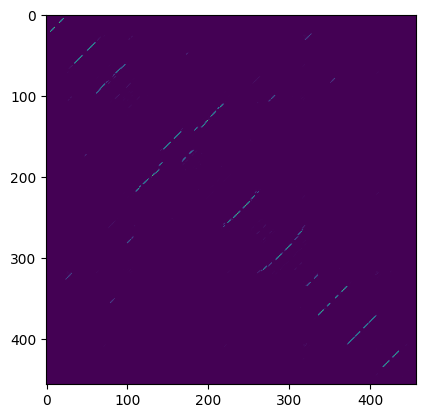

In [35]:
plt.imshow(np.stack([np.stack(res_rnaformer).mean(0), np.stack(res_vienna).mean(0), np.stack(res_org).mean(0)]).mean(0))

array([[0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.002552],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.002314],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.001044],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.002552, 0.002314, 0.001044, ..., 0.      , 0.      , 0.      ]],
      dtype=float16)